In [1]:
#Load the necessary packages
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

In [2]:
#Define the path
path = "C:/Users/lunam/OzonProject/"

In [3]:
#Load the data
df_sta_time = pd.read_csv(path + "sta_data.csv", low_memory=False)

# Stationarity test

In [4]:
#Check for stationarity with the ADF test using the adfuller function
from statsmodels.tsa.stattools import adfuller
adf, pval, usedlag, nobs, crit_vals, icbest =  adfuller(df_sta_time["StampfenbachstrOzon"])
print('ADF test statistic:', adf)
print('ADF p-values:', pval)
print('ADF number of lags used:', usedlag)
print('ADF number of observations:', nobs)
print('ADF critical values:', crit_vals)
print('ADF best information criterion:', icbest)


ADF test statistic: -8.239072316270045
ADF p-values: 5.782723668629738e-13
ADF number of lags used: 48
ADF number of observations: 25486
ADF critical values: {'1%': -3.4306066098547596, '5%': -2.8616534138818204, '10%': -2.5668303668766135}
ADF best information criterion: 168375.71139582674


The p value is above 0.05, so the null hypthesis gets rejected and the StampfenbachstrOzon time series is non-stationary 

<Axes: >

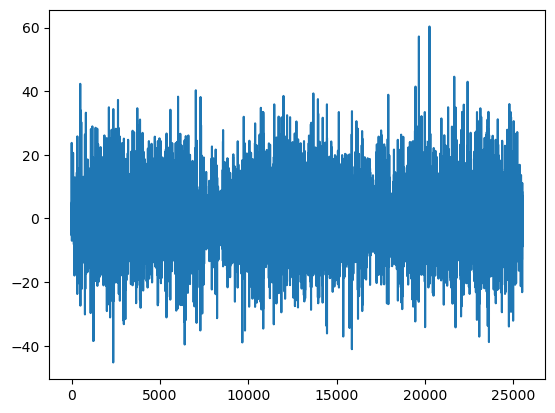

In [5]:
#Differencing ozon data to make it stationary 
prev_value = df_sta_time["StampfenbachstrOzon"].shift()
differenced = df_sta_time["StampfenbachstrOzon"] - prev_value
differenced.plot()

In [6]:
adf, pval, usedlag, nobs, crit_vals, icbest =  adfuller(differenced.dropna())
print('ADF test statistic:', adf)
print('ADF p-values:', pval)
print('ADF number of lags used:', usedlag)
print('ADF number of observations:', nobs)
print('ADF critical values:', crit_vals)
print('ADF best information criterion:', icbest)

ADF test statistic: -30.36564980583519
ADF p-values: 0.0
ADF number of lags used: 48
ADF number of observations: 25485
ADF critical values: {'1%': -3.4306066199248284, '5%': -2.8616534183322972, '10%': -2.5668303692455052}
ADF best information criterion: 168408.1094256917


The p value is now below 0.05 and suggests that the time series is now stationary after differencing once.

Auch wenn unsere Daten Non-Stationary sind, haben wir uns dafür entschieden, beim Training Non-Stationary Daten zu nutzen. Dies, da bei XGBoost und RF keine Annahmen über Zeitreihen bestehen.
https://www.researchgate.net/post/Is-it-necessary-to-make-time-series-data-stationary-before-applying-tree-based-ML-methods-ie-Random-Forest-or-Xgboost-etc

# ACF und PACF plots

### Ozon 

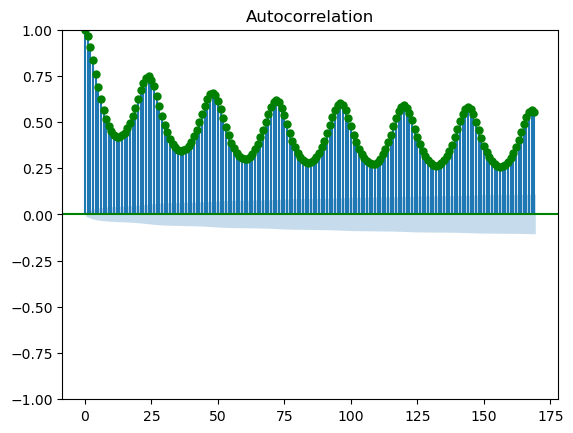

In [7]:
#plot acf 
from statsmodels.graphics.tsaplots import plot_acf
acf_sta = plot_acf(df_sta_time["StampfenbachstrOzon"], lags=169,color='g')

- Korrelation der Zeitreihe mit der verzögerten Version ihrer selbst
- Wir sehen starke saisonale Muster: Verzögerungen am Stunde 24, 48, 72 usw sind mit unseren Ozon Werten korreliert. Es gibt ein "tägliches Ozongedächtnis"

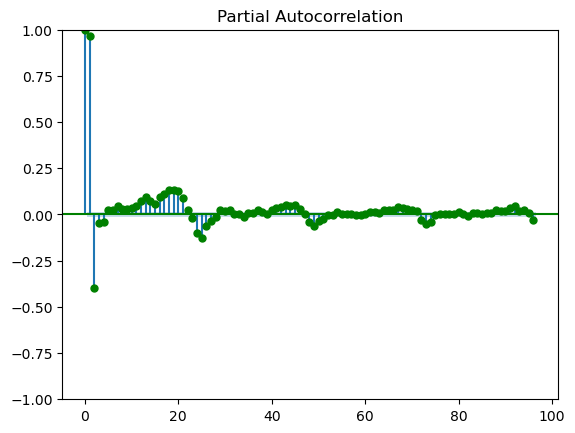

In [8]:
from statsmodels.graphics.tsaplots import plot_pacf
#plot pacf 
pacf = plot_pacf(df_sta_time["StampfenbachstrOzon"], lags=96, color='g')

- Pacf sind ähnlich wie acf, aber pacf reduzieren den Effekt von Prior Lags
- Pacf kann verwendet werden, um zu entscheiden, wie viele Verzögerungen einbezogen werden sollen.
- Wir können sehen, dass das "tägliche Ozongedächtnis" mit der Zeit schwächer wird, nach Tag 1 und insbesondere nach Tag 3 enthalten die Ozon Werte keine brauchbaren Informationen mehr

### Luftdruck

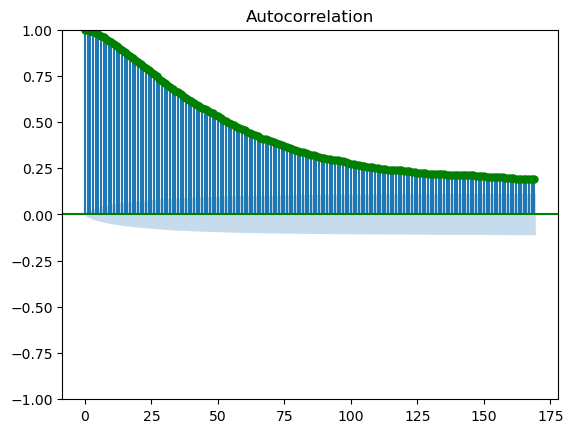

In [9]:
#plot acf 
from statsmodels.graphics.tsaplots import plot_acf
acf_sta = plot_acf(df_sta_time["Luftdruck_STA"], lags=169,color='g')

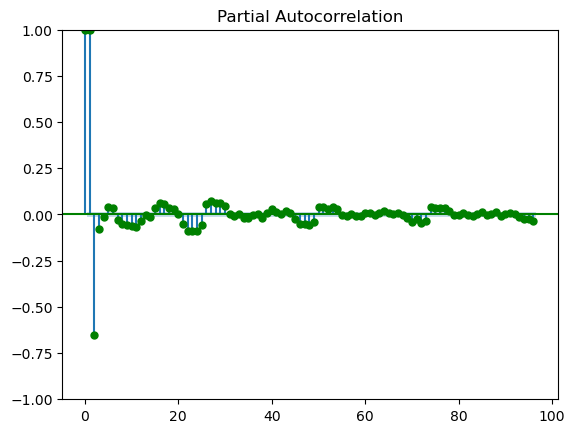

In [10]:
from statsmodels.graphics.tsaplots import plot_pacf
#plot pacf for df_sta

pacf = plot_pacf(df_sta_time["Luftdruck_STA"], lags=96, color='g')

### Lufttemperatur

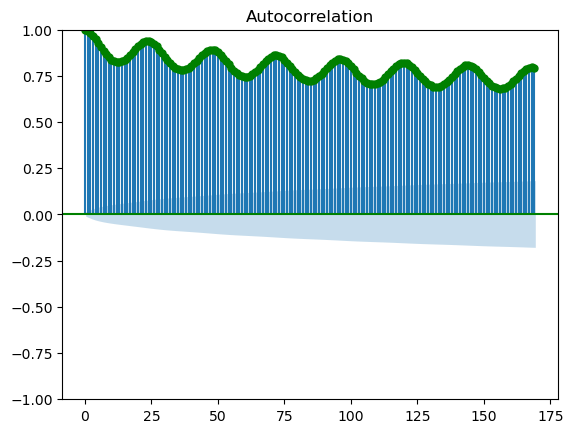

In [11]:
#plot acf 
from statsmodels.graphics.tsaplots import plot_acf
acf_sta = plot_acf(df_sta_time["Lufttemp_STA"], lags=169,color='g')

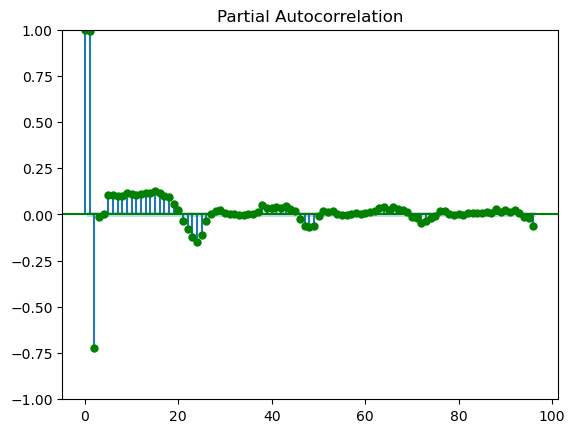

In [12]:
from statsmodels.graphics.tsaplots import plot_pacf
#plot pacf 

pacf = plot_pacf(df_sta_time["Lufttemp_STA"], lags=96, color='g')

### Windgeschwindigkeit

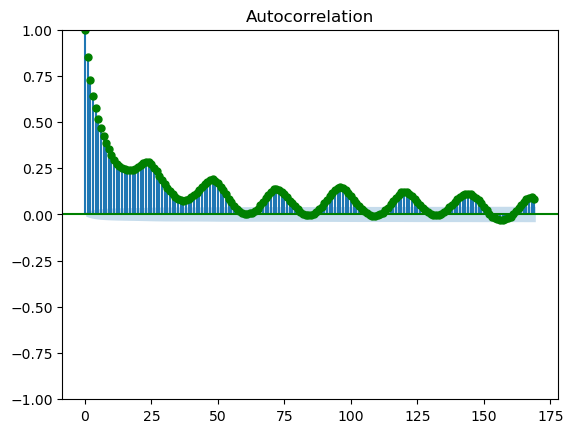

In [13]:
#plot acf 
acf_sta = plot_acf(df_sta_time["Windgeschw_STA"], lags=169,color='g')

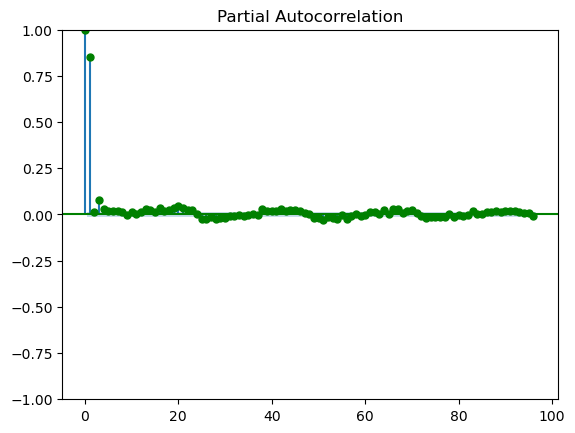

In [14]:
#plot pacf
pacf = plot_pacf(df_sta_time["Windgeschw_STA"], lags=96, color='g')

### Anzahl Fahrzeuge

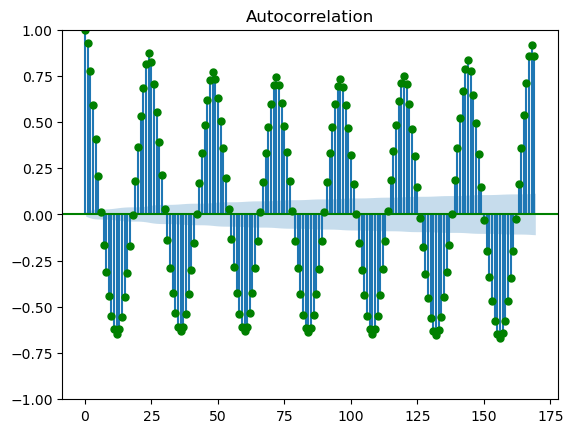

In [15]:
#plot acf 
acf_sta = plot_acf(df_sta_time["AnzFahrzeuge_STA"], lags=169,color='g')

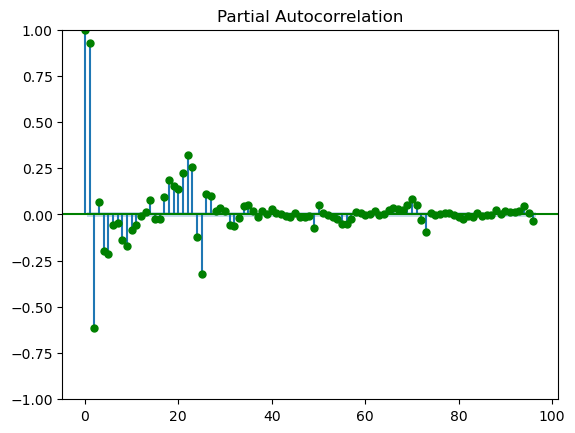

In [16]:
#plot pacf
pacf = plot_pacf(df_sta_time["AnzFahrzeuge_STA"], lags=96, color='g')

Für das Forecasting Dataset werden wir 48h Lags nutzen. Diese sind nach den PACF Plots sicherlich noch relevant. Lags von 24h wären noch relevanter. Wir wollten aber die Möglichkeit offen lassen, im Falle noch längere Zeitspannen vorherzusagen. Darüber hinaus ist es wichtig zu sagen, dass sich diese auf eine Regression beziehen.

# Seasonality

In [17]:
from statsmodels.tsa.seasonal import seasonal_decompose
#we plot the seasonality
decomp = seasonal_decompose(df_sta_time["StampfenbachstrOzon"].iloc[0:168], period=24)

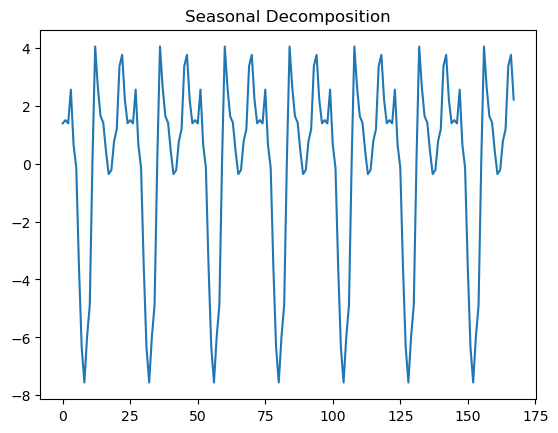

In [18]:
import matplotlib.pyplot as plt
decomp.seasonal.plot()
plt.title('Seasonal Decomposition')

# Show the plot
plt.show()

Wir können auch die saisonale Komponente der saisonalen Zersetzung verwenden. Wir sehen, dass sich dieses Muster alle 24 Studen wiederholt. Es gibt aber auch eine Art von Seasonality von 6 Stunden.

# Naive

In [19]:
# set the column 'datetime' as index
df_sta_time['datetime'] = pd.to_datetime(df_sta_time['datetime'])
df_sta_time.set_index('datetime', inplace=True)

In [20]:
test = df_sta_time[-8640:] # get last year
train = df_sta_time[0:-8640] # get data until first day of testing day

In [21]:
history = train
history

,Luftdruck_STA,Lufttemp_STA,Windgeschw_STA,StampfenbachstrOzon,AnzFahrzeuge_STA,hour_of_day,day_of_week,day_of_year,month,year
datetime,,,,,,,,,,
2021-01-01 01:00:00,954.0,2.1,4.7,8.51,1320.0,1,5,1,1,2021
2021-01-01 02:00:00,954.4,2.3,3.2,5.34,919.0,2,5,1,1,2021
2021-01-01 03:00:00,954.6,2.0,2.5,7.54,617.0,3,5,1,1,2021
2021-01-01 04:00:00,954.6,2.3,2.2,31.30,445.0,4,5,1,1,2021
2021-01-01 05:00:00,954.8,2.3,2.9,40.87,371.0,5,5,1,1,2021
...,...,...,...,...,...,...,...,...,...,...
2022-12-05 19:00:00,968.6,5.7,3.6,22.99,2781.0,19,1,339,12,2022
2022-12-05 20:00:00,968.9,5.3,2.9,22.99,2204.0,20,1,339,12,2022
2022-12-05 21:00:00,969.0,4.4,3.6,12.72,2209.0,21,1,339,12,2022


In [22]:
from sklearn.metrics import mean_squared_error

In [23]:
performance_collector = []

In [24]:
hourly_predictions_df = pd.DataFrame(columns=['Day', 'Hour', 'Predicted_Ozon', 'Actual_Ozon'])

In [25]:
#This code comes from module 8
for d in test["day_of_year"].unique():
  y_pred = pd.Series([history.tail(1)["StampfenbachstrOzon"]]*24) # get value of last hour of last day in history
  actual = test[test["day_of_year"]==d]["StampfenbachstrOzon"] # get actual values to be predicted in day d
  for h in range(24):
    actual_hourly = test[(test["hour_of_day"] == h) & (test["day_of_year"] == d)]["StampfenbachstrOzon"]
    y_pred_hourly = y_pred[h::24]  # Extract predictions for the current hour from the 24-hour prediction
    print(f'Day {d}, Hour {h}, y_pred_hourly: {y_pred_hourly.tolist()}')
    hourly_predictions_df = pd.concat([hourly_predictions_df, pd.DataFrame({'Day': [d], 'Hour': [h], 'Predicted_Ozon': [y_pred_hourly.tolist()], 'Actual_Ozon': [actual_hourly.tolist()]})], ignore_index=True)

  history = pd.concat([history, test[test["day_of_year"]==d]], ignore_index=True) # append training data to history; we shift one week forward in next iteration
  performance_collector.append(mean_squared_error(actual,y_pred, squared=False)) #calculalate error in day d

Day 340, Hour 0, y_pred_hourly: [datetime
2022-12-05 23:00:00    2.53
Name: StampfenbachstrOzon, dtype: float64]
Day 340, Hour 1, y_pred_hourly: [datetime
2022-12-05 23:00:00    2.53
Name: StampfenbachstrOzon, dtype: float64]
Day 340, Hour 2, y_pred_hourly: [datetime
2022-12-05 23:00:00    2.53
Name: StampfenbachstrOzon, dtype: float64]
Day 340, Hour 3, y_pred_hourly: [datetime
2022-12-05 23:00:00    2.53
Name: StampfenbachstrOzon, dtype: float64]
Day 340, Hour 4, y_pred_hourly: [datetime
2022-12-05 23:00:00    2.53
Name: StampfenbachstrOzon, dtype: float64]
Day 340, Hour 5, y_pred_hourly: [datetime
2022-12-05 23:00:00    2.53
Name: StampfenbachstrOzon, dtype: float64]
Day 340, Hour 6, y_pred_hourly: [datetime
2022-12-05 23:00:00    2.53
Name: StampfenbachstrOzon, dtype: float64]
Day 340, Hour 7, y_pred_hourly: [datetime
2022-12-05 23:00:00    2.53
Name: StampfenbachstrOzon, dtype: float64]
Day 340, Hour 8, y_pred_hourly: [datetime
2022-12-05 23:00:00    2.53
Name: StampfenbachstrOzon,

C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError

Day 346, Hour 3, y_pred_hourly: [17038    6.33
Name: StampfenbachstrOzon, dtype: float64]
Day 346, Hour 4, y_pred_hourly: [17038    6.33
Name: StampfenbachstrOzon, dtype: float64]
Day 346, Hour 5, y_pred_hourly: [17038    6.33
Name: StampfenbachstrOzon, dtype: float64]
Day 346, Hour 6, y_pred_hourly: [17038    6.33
Name: StampfenbachstrOzon, dtype: float64]
Day 346, Hour 7, y_pred_hourly: [17038    6.33
Name: StampfenbachstrOzon, dtype: float64]
Day 346, Hour 8, y_pred_hourly: [17038    6.33
Name: StampfenbachstrOzon, dtype: float64]
Day 346, Hour 9, y_pred_hourly: [17038    6.33
Name: StampfenbachstrOzon, dtype: float64]
Day 346, Hour 10, y_pred_hourly: [17038    6.33
Name: StampfenbachstrOzon, dtype: float64]
Day 346, Hour 11, y_pred_hourly: [17038    6.33
Name: StampfenbachstrOzon, dtype: float64]
Day 346, Hour 12, y_pred_hourly: [17038    6.33
Name: StampfenbachstrOzon, dtype: float64]
Day 346, Hour 13, y_pred_hourly: [17038    6.33
Name: StampfenbachstrOzon, dtype: float64]
Day 34

C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError

Day 352, Hour 18, y_pred_hourly: [17182    12.28
Name: StampfenbachstrOzon, dtype: float64]
Day 352, Hour 19, y_pred_hourly: [17182    12.28
Name: StampfenbachstrOzon, dtype: float64]
Day 352, Hour 20, y_pred_hourly: [17182    12.28
Name: StampfenbachstrOzon, dtype: float64]
Day 352, Hour 21, y_pred_hourly: [17182    12.28
Name: StampfenbachstrOzon, dtype: float64]
Day 352, Hour 22, y_pred_hourly: [17182    12.28
Name: StampfenbachstrOzon, dtype: float64]
Day 352, Hour 23, y_pred_hourly: [17182    12.28
Name: StampfenbachstrOzon, dtype: float64]
Day 353, Hour 0, y_pred_hourly: [17206    5.98
Name: StampfenbachstrOzon, dtype: float64]
Day 353, Hour 1, y_pred_hourly: [17206    5.98
Name: StampfenbachstrOzon, dtype: float64]
Day 353, Hour 2, y_pred_hourly: [17206    5.98
Name: StampfenbachstrOzon, dtype: float64]
Day 353, Hour 3, y_pred_hourly: [17206    5.98
Name: StampfenbachstrOzon, dtype: float64]
Day 353, Hour 4, y_pred_hourly: [17206    5.98
Name: StampfenbachstrOzon, dtype: float64

C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError

Day 359, Hour 21, y_pred_hourly: [17350    35.57
Name: StampfenbachstrOzon, dtype: float64]
Day 359, Hour 22, y_pred_hourly: [17350    35.57
Name: StampfenbachstrOzon, dtype: float64]
Day 359, Hour 23, y_pred_hourly: [17350    35.57
Name: StampfenbachstrOzon, dtype: float64]
Day 360, Hour 0, y_pred_hourly: [17374    11.94
Name: StampfenbachstrOzon, dtype: float64]
Day 360, Hour 1, y_pred_hourly: [17374    11.94
Name: StampfenbachstrOzon, dtype: float64]
Day 360, Hour 2, y_pred_hourly: [17374    11.94
Name: StampfenbachstrOzon, dtype: float64]
Day 360, Hour 3, y_pred_hourly: [17374    11.94
Name: StampfenbachstrOzon, dtype: float64]
Day 360, Hour 4, y_pred_hourly: [17374    11.94
Name: StampfenbachstrOzon, dtype: float64]
Day 360, Hour 5, y_pred_hourly: [17374    11.94
Name: StampfenbachstrOzon, dtype: float64]
Day 360, Hour 6, y_pred_hourly: [17374    11.94
Name: StampfenbachstrOzon, dtype: float64]
Day 360, Hour 7, y_pred_hourly: [17374    11.94
Name: StampfenbachstrOzon, dtype: float

C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError

Day 1, Hour 4, y_pred_hourly: [17518    5.27
Name: StampfenbachstrOzon, dtype: float64]
Day 1, Hour 5, y_pred_hourly: [17518    5.27
Name: StampfenbachstrOzon, dtype: float64]
Day 1, Hour 6, y_pred_hourly: [17518    5.27
Name: StampfenbachstrOzon, dtype: float64]
Day 1, Hour 7, y_pred_hourly: [17518    5.27
Name: StampfenbachstrOzon, dtype: float64]
Day 1, Hour 8, y_pred_hourly: [17518    5.27
Name: StampfenbachstrOzon, dtype: float64]
Day 1, Hour 9, y_pred_hourly: [17518    5.27
Name: StampfenbachstrOzon, dtype: float64]
Day 1, Hour 10, y_pred_hourly: [17518    5.27
Name: StampfenbachstrOzon, dtype: float64]
Day 1, Hour 11, y_pred_hourly: [17518    5.27
Name: StampfenbachstrOzon, dtype: float64]
Day 1, Hour 12, y_pred_hourly: [17518    5.27
Name: StampfenbachstrOzon, dtype: float64]
Day 1, Hour 13, y_pred_hourly: [17518    5.27
Name: StampfenbachstrOzon, dtype: float64]
Day 1, Hour 14, y_pred_hourly: [17518    5.27
Name: StampfenbachstrOzon, dtype: float64]
Day 1, Hour 15, y_pred_hour

C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError

Day 7, Hour 9, y_pred_hourly: [17662    28.39
Name: StampfenbachstrOzon, dtype: float64]
Day 7, Hour 10, y_pred_hourly: [17662    28.39
Name: StampfenbachstrOzon, dtype: float64]
Day 7, Hour 11, y_pred_hourly: [17662    28.39
Name: StampfenbachstrOzon, dtype: float64]
Day 7, Hour 12, y_pred_hourly: [17662    28.39
Name: StampfenbachstrOzon, dtype: float64]
Day 7, Hour 13, y_pred_hourly: [17662    28.39
Name: StampfenbachstrOzon, dtype: float64]
Day 7, Hour 14, y_pred_hourly: [17662    28.39
Name: StampfenbachstrOzon, dtype: float64]
Day 7, Hour 15, y_pred_hourly: [17662    28.39
Name: StampfenbachstrOzon, dtype: float64]
Day 7, Hour 16, y_pred_hourly: [17662    28.39
Name: StampfenbachstrOzon, dtype: float64]
Day 7, Hour 17, y_pred_hourly: [17662    28.39
Name: StampfenbachstrOzon, dtype: float64]
Day 7, Hour 18, y_pred_hourly: [17662    28.39
Name: StampfenbachstrOzon, dtype: float64]
Day 7, Hour 19, y_pred_hourly: [17662    28.39
Name: StampfenbachstrOzon, dtype: float64]
Day 7, Hour

C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError

Day 14, Hour 4, y_pred_hourly: [17830    70.5
Name: StampfenbachstrOzon, dtype: float64]
Day 14, Hour 5, y_pred_hourly: [17830    70.5
Name: StampfenbachstrOzon, dtype: float64]
Day 14, Hour 6, y_pred_hourly: [17830    70.5
Name: StampfenbachstrOzon, dtype: float64]
Day 14, Hour 7, y_pred_hourly: [17830    70.5
Name: StampfenbachstrOzon, dtype: float64]
Day 14, Hour 8, y_pred_hourly: [17830    70.5
Name: StampfenbachstrOzon, dtype: float64]
Day 14, Hour 9, y_pred_hourly: [17830    70.5
Name: StampfenbachstrOzon, dtype: float64]
Day 14, Hour 10, y_pred_hourly: [17830    70.5
Name: StampfenbachstrOzon, dtype: float64]
Day 14, Hour 11, y_pred_hourly: [17830    70.5
Name: StampfenbachstrOzon, dtype: float64]
Day 14, Hour 12, y_pred_hourly: [17830    70.5
Name: StampfenbachstrOzon, dtype: float64]
Day 14, Hour 13, y_pred_hourly: [17830    70.5
Name: StampfenbachstrOzon, dtype: float64]
Day 14, Hour 14, y_pred_hourly: [17830    70.5
Name: StampfenbachstrOzon, dtype: float64]
Day 14, Hour 15,

C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError

Day 19, Hour 22, y_pred_hourly: [17950    40.45
Name: StampfenbachstrOzon, dtype: float64]
Day 19, Hour 23, y_pred_hourly: [17950    40.45
Name: StampfenbachstrOzon, dtype: float64]
Day 20, Hour 0, y_pred_hourly: [17974    35.8
Name: StampfenbachstrOzon, dtype: float64]
Day 20, Hour 1, y_pred_hourly: [17974    35.8
Name: StampfenbachstrOzon, dtype: float64]
Day 20, Hour 2, y_pred_hourly: [17974    35.8
Name: StampfenbachstrOzon, dtype: float64]
Day 20, Hour 3, y_pred_hourly: [17974    35.8
Name: StampfenbachstrOzon, dtype: float64]
Day 20, Hour 4, y_pred_hourly: [17974    35.8
Name: StampfenbachstrOzon, dtype: float64]
Day 20, Hour 5, y_pred_hourly: [17974    35.8
Name: StampfenbachstrOzon, dtype: float64]
Day 20, Hour 6, y_pred_hourly: [17974    35.8
Name: StampfenbachstrOzon, dtype: float64]
Day 20, Hour 7, y_pred_hourly: [17974    35.8
Name: StampfenbachstrOzon, dtype: float64]
Day 20, Hour 8, y_pred_hourly: [17974    35.8
Name: StampfenbachstrOzon, dtype: float64]
Day 20, Hour 9, y

C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError

Day 26, Hour 8, y_pred_hourly: [18118    30.92
Name: StampfenbachstrOzon, dtype: float64]
Day 26, Hour 9, y_pred_hourly: [18118    30.92
Name: StampfenbachstrOzon, dtype: float64]
Day 26, Hour 10, y_pred_hourly: [18118    30.92
Name: StampfenbachstrOzon, dtype: float64]
Day 26, Hour 11, y_pred_hourly: [18118    30.92
Name: StampfenbachstrOzon, dtype: float64]
Day 26, Hour 12, y_pred_hourly: [18118    30.92
Name: StampfenbachstrOzon, dtype: float64]
Day 26, Hour 13, y_pred_hourly: [18118    30.92
Name: StampfenbachstrOzon, dtype: float64]
Day 26, Hour 14, y_pred_hourly: [18118    30.92
Name: StampfenbachstrOzon, dtype: float64]
Day 26, Hour 15, y_pred_hourly: [18118    30.92
Name: StampfenbachstrOzon, dtype: float64]
Day 26, Hour 16, y_pred_hourly: [18118    30.92
Name: StampfenbachstrOzon, dtype: float64]
Day 26, Hour 17, y_pred_hourly: [18118    30.92
Name: StampfenbachstrOzon, dtype: float64]
Day 26, Hour 18, y_pred_hourly: [18118    30.92
Name: StampfenbachstrOzon, dtype: float64]
D

C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError

Day 32, Hour 16, y_pred_hourly: [18262    50.56
Name: StampfenbachstrOzon, dtype: float64]
Day 32, Hour 17, y_pred_hourly: [18262    50.56
Name: StampfenbachstrOzon, dtype: float64]
Day 32, Hour 18, y_pred_hourly: [18262    50.56
Name: StampfenbachstrOzon, dtype: float64]
Day 32, Hour 19, y_pred_hourly: [18262    50.56
Name: StampfenbachstrOzon, dtype: float64]
Day 32, Hour 20, y_pred_hourly: [18262    50.56
Name: StampfenbachstrOzon, dtype: float64]
Day 32, Hour 21, y_pred_hourly: [18262    50.56
Name: StampfenbachstrOzon, dtype: float64]
Day 32, Hour 22, y_pred_hourly: [18262    50.56
Name: StampfenbachstrOzon, dtype: float64]
Day 32, Hour 23, y_pred_hourly: [18262    50.56
Name: StampfenbachstrOzon, dtype: float64]
Day 33, Hour 0, y_pred_hourly: [18286    72.42
Name: StampfenbachstrOzon, dtype: float64]
Day 33, Hour 1, y_pred_hourly: [18286    72.42
Name: StampfenbachstrOzon, dtype: float64]
Day 33, Hour 2, y_pred_hourly: [18286    72.42
Name: StampfenbachstrOzon, dtype: float64]
Da

C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError

Day 38, Hour 20, y_pred_hourly: [18406    47.43
Name: StampfenbachstrOzon, dtype: float64]
Day 38, Hour 21, y_pred_hourly: [18406    47.43
Name: StampfenbachstrOzon, dtype: float64]
Day 38, Hour 22, y_pred_hourly: [18406    47.43
Name: StampfenbachstrOzon, dtype: float64]
Day 38, Hour 23, y_pred_hourly: [18406    47.43
Name: StampfenbachstrOzon, dtype: float64]
Day 39, Hour 0, y_pred_hourly: [18430    17.11
Name: StampfenbachstrOzon, dtype: float64]
Day 39, Hour 1, y_pred_hourly: [18430    17.11
Name: StampfenbachstrOzon, dtype: float64]
Day 39, Hour 2, y_pred_hourly: [18430    17.11
Name: StampfenbachstrOzon, dtype: float64]
Day 39, Hour 3, y_pred_hourly: [18430    17.11
Name: StampfenbachstrOzon, dtype: float64]
Day 39, Hour 4, y_pred_hourly: [18430    17.11
Name: StampfenbachstrOzon, dtype: float64]
Day 39, Hour 5, y_pred_hourly: [18430    17.11
Name: StampfenbachstrOzon, dtype: float64]
Day 39, Hour 6, y_pred_hourly: [18430    17.11
Name: StampfenbachstrOzon, dtype: float64]
Day 39

C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError

Day 44, Hour 12, y_pred_hourly: [18550    16.11
Name: StampfenbachstrOzon, dtype: float64]
Day 44, Hour 13, y_pred_hourly: [18550    16.11
Name: StampfenbachstrOzon, dtype: float64]
Day 44, Hour 14, y_pred_hourly: [18550    16.11
Name: StampfenbachstrOzon, dtype: float64]
Day 44, Hour 15, y_pred_hourly: [18550    16.11
Name: StampfenbachstrOzon, dtype: float64]
Day 44, Hour 16, y_pred_hourly: [18550    16.11
Name: StampfenbachstrOzon, dtype: float64]
Day 44, Hour 17, y_pred_hourly: [18550    16.11
Name: StampfenbachstrOzon, dtype: float64]
Day 44, Hour 18, y_pred_hourly: [18550    16.11
Name: StampfenbachstrOzon, dtype: float64]
Day 44, Hour 19, y_pred_hourly: [18550    16.11
Name: StampfenbachstrOzon, dtype: float64]
Day 44, Hour 20, y_pred_hourly: [18550    16.11
Name: StampfenbachstrOzon, dtype: float64]
Day 44, Hour 21, y_pred_hourly: [18550    16.11
Name: StampfenbachstrOzon, dtype: float64]
Day 44, Hour 22, y_pred_hourly: [18550    16.11
Name: StampfenbachstrOzon, dtype: float64]

C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError

Day 50, Hour 22, y_pred_hourly: [18694    48.05
Name: StampfenbachstrOzon, dtype: float64]
Day 50, Hour 23, y_pred_hourly: [18694    48.05
Name: StampfenbachstrOzon, dtype: float64]
Day 51, Hour 0, y_pred_hourly: [18718    61.49
Name: StampfenbachstrOzon, dtype: float64]
Day 51, Hour 1, y_pred_hourly: [18718    61.49
Name: StampfenbachstrOzon, dtype: float64]
Day 51, Hour 2, y_pred_hourly: [18718    61.49
Name: StampfenbachstrOzon, dtype: float64]
Day 51, Hour 3, y_pred_hourly: [18718    61.49
Name: StampfenbachstrOzon, dtype: float64]
Day 51, Hour 4, y_pred_hourly: [18718    61.49
Name: StampfenbachstrOzon, dtype: float64]
Day 51, Hour 5, y_pred_hourly: [18718    61.49
Name: StampfenbachstrOzon, dtype: float64]
Day 51, Hour 6, y_pred_hourly: [18718    61.49
Name: StampfenbachstrOzon, dtype: float64]
Day 51, Hour 7, y_pred_hourly: [18718    61.49
Name: StampfenbachstrOzon, dtype: float64]
Day 51, Hour 8, y_pred_hourly: [18718    61.49
Name: StampfenbachstrOzon, dtype: float64]
Day 51, 

C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError

Day 55, Hour 3, y_pred_hourly: [18814    3.11
Name: StampfenbachstrOzon, dtype: float64]
Day 55, Hour 4, y_pred_hourly: [18814    3.11
Name: StampfenbachstrOzon, dtype: float64]
Day 55, Hour 5, y_pred_hourly: [18814    3.11
Name: StampfenbachstrOzon, dtype: float64]
Day 55, Hour 6, y_pred_hourly: [18814    3.11
Name: StampfenbachstrOzon, dtype: float64]
Day 55, Hour 7, y_pred_hourly: [18814    3.11
Name: StampfenbachstrOzon, dtype: float64]
Day 55, Hour 8, y_pred_hourly: [18814    3.11
Name: StampfenbachstrOzon, dtype: float64]
Day 55, Hour 9, y_pred_hourly: [18814    3.11
Name: StampfenbachstrOzon, dtype: float64]
Day 55, Hour 10, y_pred_hourly: [18814    3.11
Name: StampfenbachstrOzon, dtype: float64]
Day 55, Hour 11, y_pred_hourly: [18814    3.11
Name: StampfenbachstrOzon, dtype: float64]
Day 55, Hour 12, y_pred_hourly: [18814    3.11
Name: StampfenbachstrOzon, dtype: float64]
Day 55, Hour 13, y_pred_hourly: [18814    3.11
Name: StampfenbachstrOzon, dtype: float64]
Day 55, Hour 14, 

C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError

Day 60, Hour 20, y_pred_hourly: [18934    41.74
Name: StampfenbachstrOzon, dtype: float64]
Day 60, Hour 21, y_pred_hourly: [18934    41.74
Name: StampfenbachstrOzon, dtype: float64]
Day 60, Hour 22, y_pred_hourly: [18934    41.74
Name: StampfenbachstrOzon, dtype: float64]
Day 60, Hour 23, y_pred_hourly: [18934    41.74
Name: StampfenbachstrOzon, dtype: float64]
Day 61, Hour 0, y_pred_hourly: [18958    35.88
Name: StampfenbachstrOzon, dtype: float64]
Day 61, Hour 1, y_pred_hourly: [18958    35.88
Name: StampfenbachstrOzon, dtype: float64]
Day 61, Hour 2, y_pred_hourly: [18958    35.88
Name: StampfenbachstrOzon, dtype: float64]
Day 61, Hour 3, y_pred_hourly: [18958    35.88
Name: StampfenbachstrOzon, dtype: float64]
Day 61, Hour 4, y_pred_hourly: [18958    35.88
Name: StampfenbachstrOzon, dtype: float64]
Day 61, Hour 5, y_pred_hourly: [18958    35.88
Name: StampfenbachstrOzon, dtype: float64]
Day 61, Hour 6, y_pred_hourly: [18958    35.88
Name: StampfenbachstrOzon, dtype: float64]
Day 61

C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError

Day 66, Hour 3, y_pred_hourly: [19078    65.88
Name: StampfenbachstrOzon, dtype: float64]
Day 66, Hour 4, y_pred_hourly: [19078    65.88
Name: StampfenbachstrOzon, dtype: float64]
Day 66, Hour 5, y_pred_hourly: [19078    65.88
Name: StampfenbachstrOzon, dtype: float64]
Day 66, Hour 6, y_pred_hourly: [19078    65.88
Name: StampfenbachstrOzon, dtype: float64]
Day 66, Hour 7, y_pred_hourly: [19078    65.88
Name: StampfenbachstrOzon, dtype: float64]
Day 66, Hour 8, y_pred_hourly: [19078    65.88
Name: StampfenbachstrOzon, dtype: float64]
Day 66, Hour 9, y_pred_hourly: [19078    65.88
Name: StampfenbachstrOzon, dtype: float64]
Day 66, Hour 10, y_pred_hourly: [19078    65.88
Name: StampfenbachstrOzon, dtype: float64]
Day 66, Hour 11, y_pred_hourly: [19078    65.88
Name: StampfenbachstrOzon, dtype: float64]
Day 66, Hour 12, y_pred_hourly: [19078    65.88
Name: StampfenbachstrOzon, dtype: float64]
Day 66, Hour 13, y_pred_hourly: [19078    65.88
Name: StampfenbachstrOzon, dtype: float64]
Day 66

Day 71, Hour 14, y_pred_hourly: [19198    45.94
Name: StampfenbachstrOzon, dtype: float64]
Day 71, Hour 15, y_pred_hourly: [19198    45.94
Name: StampfenbachstrOzon, dtype: float64]
Day 71, Hour 16, y_pred_hourly: [19198    45.94
Name: StampfenbachstrOzon, dtype: float64]
Day 71, Hour 17, y_pred_hourly: [19198    45.94
Name: StampfenbachstrOzon, dtype: float64]
Day 71, Hour 18, y_pred_hourly: [19198    45.94
Name: StampfenbachstrOzon, dtype: float64]
Day 71, Hour 19, y_pred_hourly: [19198    45.94
Name: StampfenbachstrOzon, dtype: float64]
Day 71, Hour 20, y_pred_hourly: [19198    45.94
Name: StampfenbachstrOzon, dtype: float64]
Day 71, Hour 21, y_pred_hourly: [19198    45.94
Name: StampfenbachstrOzon, dtype: float64]
Day 71, Hour 22, y_pred_hourly: [19198    45.94
Name: StampfenbachstrOzon, dtype: float64]
Day 71, Hour 23, y_pred_hourly: [19198    45.94
Name: StampfenbachstrOzon, dtype: float64]
Day 72, Hour 0, y_pred_hourly: [19222    40.32
Name: StampfenbachstrOzon, dtype: float64]


C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError

Day 77, Hour 19, y_pred_hourly: [19342    3.71
Name: StampfenbachstrOzon, dtype: float64]
Day 77, Hour 20, y_pred_hourly: [19342    3.71
Name: StampfenbachstrOzon, dtype: float64]
Day 77, Hour 21, y_pred_hourly: [19342    3.71
Name: StampfenbachstrOzon, dtype: float64]
Day 77, Hour 22, y_pred_hourly: [19342    3.71
Name: StampfenbachstrOzon, dtype: float64]
Day 77, Hour 23, y_pred_hourly: [19342    3.71
Name: StampfenbachstrOzon, dtype: float64]
Day 78, Hour 0, y_pred_hourly: [19366    88.24
Name: StampfenbachstrOzon, dtype: float64]
Day 78, Hour 1, y_pred_hourly: [19366    88.24
Name: StampfenbachstrOzon, dtype: float64]
Day 78, Hour 2, y_pred_hourly: [19366    88.24
Name: StampfenbachstrOzon, dtype: float64]
Day 78, Hour 3, y_pred_hourly: [19366    88.24
Name: StampfenbachstrOzon, dtype: float64]
Day 78, Hour 4, y_pred_hourly: [19366    88.24
Name: StampfenbachstrOzon, dtype: float64]
Day 78, Hour 5, y_pred_hourly: [19366    88.24
Name: StampfenbachstrOzon, dtype: float64]
Day 78, Ho

C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError

Day 83, Hour 6, y_pred_hourly: [19486    43.33
Name: StampfenbachstrOzon, dtype: float64]
Day 83, Hour 7, y_pred_hourly: [19486    43.33
Name: StampfenbachstrOzon, dtype: float64]
Day 83, Hour 8, y_pred_hourly: [19486    43.33
Name: StampfenbachstrOzon, dtype: float64]
Day 83, Hour 9, y_pred_hourly: [19486    43.33
Name: StampfenbachstrOzon, dtype: float64]
Day 83, Hour 10, y_pred_hourly: [19486    43.33
Name: StampfenbachstrOzon, dtype: float64]
Day 83, Hour 11, y_pred_hourly: [19486    43.33
Name: StampfenbachstrOzon, dtype: float64]
Day 83, Hour 12, y_pred_hourly: [19486    43.33
Name: StampfenbachstrOzon, dtype: float64]
Day 83, Hour 13, y_pred_hourly: [19486    43.33
Name: StampfenbachstrOzon, dtype: float64]
Day 83, Hour 14, y_pred_hourly: [19486    43.33
Name: StampfenbachstrOzon, dtype: float64]
Day 83, Hour 15, y_pred_hourly: [19486    43.33
Name: StampfenbachstrOzon, dtype: float64]
Day 83, Hour 16, y_pred_hourly: [19486    43.33
Name: StampfenbachstrOzon, dtype: float64]
Day

C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError

Day 88, Hour 18, y_pred_hourly: [19606    65.43
Name: StampfenbachstrOzon, dtype: float64]
Day 88, Hour 19, y_pred_hourly: [19606    65.43
Name: StampfenbachstrOzon, dtype: float64]
Day 88, Hour 20, y_pred_hourly: [19606    65.43
Name: StampfenbachstrOzon, dtype: float64]
Day 88, Hour 21, y_pred_hourly: [19606    65.43
Name: StampfenbachstrOzon, dtype: float64]
Day 88, Hour 22, y_pred_hourly: [19606    65.43
Name: StampfenbachstrOzon, dtype: float64]
Day 88, Hour 23, y_pred_hourly: [19606    65.43
Name: StampfenbachstrOzon, dtype: float64]
Day 89, Hour 0, y_pred_hourly: [19630    41.4
Name: StampfenbachstrOzon, dtype: float64]
Day 89, Hour 1, y_pred_hourly: [19630    41.4
Name: StampfenbachstrOzon, dtype: float64]
Day 89, Hour 2, y_pred_hourly: [19630    41.4
Name: StampfenbachstrOzon, dtype: float64]
Day 89, Hour 3, y_pred_hourly: [19630    41.4
Name: StampfenbachstrOzon, dtype: float64]
Day 89, Hour 4, y_pred_hourly: [19630    41.4
Name: StampfenbachstrOzon, dtype: float64]
Day 89, H

C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)


Day 92, Hour 12, y_pred_hourly: [19702    54.54
Name: StampfenbachstrOzon, dtype: float64]
Day 92, Hour 13, y_pred_hourly: [19702    54.54
Name: StampfenbachstrOzon, dtype: float64]
Day 92, Hour 14, y_pred_hourly: [19702    54.54
Name: StampfenbachstrOzon, dtype: float64]
Day 92, Hour 15, y_pred_hourly: [19702    54.54
Name: StampfenbachstrOzon, dtype: float64]
Day 92, Hour 16, y_pred_hourly: [19702    54.54
Name: StampfenbachstrOzon, dtype: float64]
Day 92, Hour 17, y_pred_hourly: [19702    54.54
Name: StampfenbachstrOzon, dtype: float64]
Day 92, Hour 18, y_pred_hourly: [19702    54.54
Name: StampfenbachstrOzon, dtype: float64]
Day 92, Hour 19, y_pred_hourly: [19702    54.54
Name: StampfenbachstrOzon, dtype: float64]
Day 92, Hour 20, y_pred_hourly: [19702    54.54
Name: StampfenbachstrOzon, dtype: float64]
Day 92, Hour 21, y_pred_hourly: [19702    54.54
Name: StampfenbachstrOzon, dtype: float64]
Day 92, Hour 22, y_pred_hourly: [19702    54.54
Name: StampfenbachstrOzon, dtype: float64]

C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError

Day 98, Hour 9, y_pred_hourly: [19846    51.88
Name: StampfenbachstrOzon, dtype: float64]
Day 98, Hour 10, y_pred_hourly: [19846    51.88
Name: StampfenbachstrOzon, dtype: float64]
Day 98, Hour 11, y_pred_hourly: [19846    51.88
Name: StampfenbachstrOzon, dtype: float64]
Day 98, Hour 12, y_pred_hourly: [19846    51.88
Name: StampfenbachstrOzon, dtype: float64]
Day 98, Hour 13, y_pred_hourly: [19846    51.88
Name: StampfenbachstrOzon, dtype: float64]
Day 98, Hour 14, y_pred_hourly: [19846    51.88
Name: StampfenbachstrOzon, dtype: float64]
Day 98, Hour 15, y_pred_hourly: [19846    51.88
Name: StampfenbachstrOzon, dtype: float64]
Day 98, Hour 16, y_pred_hourly: [19846    51.88
Name: StampfenbachstrOzon, dtype: float64]
Day 98, Hour 17, y_pred_hourly: [19846    51.88
Name: StampfenbachstrOzon, dtype: float64]
Day 98, Hour 18, y_pred_hourly: [19846    51.88
Name: StampfenbachstrOzon, dtype: float64]
Day 98, Hour 19, y_pred_hourly: [19846    51.88
Name: StampfenbachstrOzon, dtype: float64]


C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError

Day 104, Hour 0, y_pred_hourly: [19990    73.42
Name: StampfenbachstrOzon, dtype: float64]
Day 104, Hour 1, y_pred_hourly: [19990    73.42
Name: StampfenbachstrOzon, dtype: float64]
Day 104, Hour 2, y_pred_hourly: [19990    73.42
Name: StampfenbachstrOzon, dtype: float64]
Day 104, Hour 3, y_pred_hourly: [19990    73.42
Name: StampfenbachstrOzon, dtype: float64]
Day 104, Hour 4, y_pred_hourly: [19990    73.42
Name: StampfenbachstrOzon, dtype: float64]
Day 104, Hour 5, y_pred_hourly: [19990    73.42
Name: StampfenbachstrOzon, dtype: float64]
Day 104, Hour 6, y_pred_hourly: [19990    73.42
Name: StampfenbachstrOzon, dtype: float64]
Day 104, Hour 7, y_pred_hourly: [19990    73.42
Name: StampfenbachstrOzon, dtype: float64]
Day 104, Hour 8, y_pred_hourly: [19990    73.42
Name: StampfenbachstrOzon, dtype: float64]
Day 104, Hour 9, y_pred_hourly: [19990    73.42
Name: StampfenbachstrOzon, dtype: float64]
Day 104, Hour 10, y_pred_hourly: [19990    73.42
Name: StampfenbachstrOzon, dtype: float64

Day 110, Hour 10, y_pred_hourly: [20134    80.31
Name: StampfenbachstrOzon, dtype: float64]
Day 110, Hour 11, y_pred_hourly: [20134    80.31
Name: StampfenbachstrOzon, dtype: float64]
Day 110, Hour 12, y_pred_hourly: [20134    80.31
Name: StampfenbachstrOzon, dtype: float64]
Day 110, Hour 13, y_pred_hourly: [20134    80.31
Name: StampfenbachstrOzon, dtype: float64]
Day 110, Hour 14, y_pred_hourly: [20134    80.31
Name: StampfenbachstrOzon, dtype: float64]
Day 110, Hour 15, y_pred_hourly: [20134    80.31
Name: StampfenbachstrOzon, dtype: float64]
Day 110, Hour 16, y_pred_hourly: [20134    80.31
Name: StampfenbachstrOzon, dtype: float64]
Day 110, Hour 17, y_pred_hourly: [20134    80.31
Name: StampfenbachstrOzon, dtype: float64]
Day 110, Hour 18, y_pred_hourly: [20134    80.31
Name: StampfenbachstrOzon, dtype: float64]
Day 110, Hour 19, y_pred_hourly: [20134    80.31
Name: StampfenbachstrOzon, dtype: float64]
Day 110, Hour 20, y_pred_hourly: [20134    80.31
Name: StampfenbachstrOzon, dtyp

C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError

Day 116, Hour 0, y_pred_hourly: [20278    69.16
Name: StampfenbachstrOzon, dtype: float64]
Day 116, Hour 1, y_pred_hourly: [20278    69.16
Name: StampfenbachstrOzon, dtype: float64]
Day 116, Hour 2, y_pred_hourly: [20278    69.16
Name: StampfenbachstrOzon, dtype: float64]
Day 116, Hour 3, y_pred_hourly: [20278    69.16
Name: StampfenbachstrOzon, dtype: float64]
Day 116, Hour 4, y_pred_hourly: [20278    69.16
Name: StampfenbachstrOzon, dtype: float64]
Day 116, Hour 5, y_pred_hourly: [20278    69.16
Name: StampfenbachstrOzon, dtype: float64]
Day 116, Hour 6, y_pred_hourly: [20278    69.16
Name: StampfenbachstrOzon, dtype: float64]
Day 116, Hour 7, y_pred_hourly: [20278    69.16
Name: StampfenbachstrOzon, dtype: float64]
Day 116, Hour 8, y_pred_hourly: [20278    69.16
Name: StampfenbachstrOzon, dtype: float64]
Day 116, Hour 9, y_pred_hourly: [20278    69.16
Name: StampfenbachstrOzon, dtype: float64]
Day 116, Hour 10, y_pred_hourly: [20278    69.16
Name: StampfenbachstrOzon, dtype: float64

C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError

Day 121, Hour 23, y_pred_hourly: [20398    64.95
Name: StampfenbachstrOzon, dtype: float64]
Day 122, Hour 0, y_pred_hourly: [20422    51.44
Name: StampfenbachstrOzon, dtype: float64]
Day 122, Hour 1, y_pred_hourly: [20422    51.44
Name: StampfenbachstrOzon, dtype: float64]
Day 122, Hour 2, y_pred_hourly: [20422    51.44
Name: StampfenbachstrOzon, dtype: float64]
Day 122, Hour 3, y_pred_hourly: [20422    51.44
Name: StampfenbachstrOzon, dtype: float64]
Day 122, Hour 4, y_pred_hourly: [20422    51.44
Name: StampfenbachstrOzon, dtype: float64]
Day 122, Hour 5, y_pred_hourly: [20422    51.44
Name: StampfenbachstrOzon, dtype: float64]
Day 122, Hour 6, y_pred_hourly: [20422    51.44
Name: StampfenbachstrOzon, dtype: float64]
Day 122, Hour 7, y_pred_hourly: [20422    51.44
Name: StampfenbachstrOzon, dtype: float64]
Day 122, Hour 8, y_pred_hourly: [20422    51.44
Name: StampfenbachstrOzon, dtype: float64]
Day 122, Hour 9, y_pred_hourly: [20422    51.44
Name: StampfenbachstrOzon, dtype: float64

C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError

Day 127, Hour 12, y_pred_hourly: [20542    78.21
Name: StampfenbachstrOzon, dtype: float64]
Day 127, Hour 13, y_pred_hourly: [20542    78.21
Name: StampfenbachstrOzon, dtype: float64]
Day 127, Hour 14, y_pred_hourly: [20542    78.21
Name: StampfenbachstrOzon, dtype: float64]
Day 127, Hour 15, y_pred_hourly: [20542    78.21
Name: StampfenbachstrOzon, dtype: float64]
Day 127, Hour 16, y_pred_hourly: [20542    78.21
Name: StampfenbachstrOzon, dtype: float64]
Day 127, Hour 17, y_pred_hourly: [20542    78.21
Name: StampfenbachstrOzon, dtype: float64]
Day 127, Hour 18, y_pred_hourly: [20542    78.21
Name: StampfenbachstrOzon, dtype: float64]
Day 127, Hour 19, y_pred_hourly: [20542    78.21
Name: StampfenbachstrOzon, dtype: float64]
Day 127, Hour 20, y_pred_hourly: [20542    78.21
Name: StampfenbachstrOzon, dtype: float64]
Day 127, Hour 21, y_pred_hourly: [20542    78.21
Name: StampfenbachstrOzon, dtype: float64]
Day 127, Hour 22, y_pred_hourly: [20542    78.21
Name: StampfenbachstrOzon, dtyp

C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError

Day 133, Hour 11, y_pred_hourly: [20686    48.38
Name: StampfenbachstrOzon, dtype: float64]
Day 133, Hour 12, y_pred_hourly: [20686    48.38
Name: StampfenbachstrOzon, dtype: float64]
Day 133, Hour 13, y_pred_hourly: [20686    48.38
Name: StampfenbachstrOzon, dtype: float64]
Day 133, Hour 14, y_pred_hourly: [20686    48.38
Name: StampfenbachstrOzon, dtype: float64]
Day 133, Hour 15, y_pred_hourly: [20686    48.38
Name: StampfenbachstrOzon, dtype: float64]
Day 133, Hour 16, y_pred_hourly: [20686    48.38
Name: StampfenbachstrOzon, dtype: float64]
Day 133, Hour 17, y_pred_hourly: [20686    48.38
Name: StampfenbachstrOzon, dtype: float64]
Day 133, Hour 18, y_pred_hourly: [20686    48.38
Name: StampfenbachstrOzon, dtype: float64]
Day 133, Hour 19, y_pred_hourly: [20686    48.38
Name: StampfenbachstrOzon, dtype: float64]
Day 133, Hour 20, y_pred_hourly: [20686    48.38
Name: StampfenbachstrOzon, dtype: float64]
Day 133, Hour 21, y_pred_hourly: [20686    48.38
Name: StampfenbachstrOzon, dtyp

C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError

Day 139, Hour 5, y_pred_hourly: [20830    79.09
Name: StampfenbachstrOzon, dtype: float64]
Day 139, Hour 6, y_pred_hourly: [20830    79.09
Name: StampfenbachstrOzon, dtype: float64]
Day 139, Hour 7, y_pred_hourly: [20830    79.09
Name: StampfenbachstrOzon, dtype: float64]
Day 139, Hour 8, y_pred_hourly: [20830    79.09
Name: StampfenbachstrOzon, dtype: float64]
Day 139, Hour 9, y_pred_hourly: [20830    79.09
Name: StampfenbachstrOzon, dtype: float64]
Day 139, Hour 10, y_pred_hourly: [20830    79.09
Name: StampfenbachstrOzon, dtype: float64]
Day 139, Hour 11, y_pred_hourly: [20830    79.09
Name: StampfenbachstrOzon, dtype: float64]
Day 139, Hour 12, y_pred_hourly: [20830    79.09
Name: StampfenbachstrOzon, dtype: float64]
Day 139, Hour 13, y_pred_hourly: [20830    79.09
Name: StampfenbachstrOzon, dtype: float64]
Day 139, Hour 14, y_pred_hourly: [20830    79.09
Name: StampfenbachstrOzon, dtype: float64]
Day 139, Hour 15, y_pred_hourly: [20830    79.09
Name: StampfenbachstrOzon, dtype: fl

C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError

Day 143, Hour 14, y_pred_hourly: [20926    45.19
Name: StampfenbachstrOzon, dtype: float64]
Day 143, Hour 15, y_pred_hourly: [20926    45.19
Name: StampfenbachstrOzon, dtype: float64]
Day 143, Hour 16, y_pred_hourly: [20926    45.19
Name: StampfenbachstrOzon, dtype: float64]
Day 143, Hour 17, y_pred_hourly: [20926    45.19
Name: StampfenbachstrOzon, dtype: float64]
Day 143, Hour 18, y_pred_hourly: [20926    45.19
Name: StampfenbachstrOzon, dtype: float64]
Day 143, Hour 19, y_pred_hourly: [20926    45.19
Name: StampfenbachstrOzon, dtype: float64]
Day 143, Hour 20, y_pred_hourly: [20926    45.19
Name: StampfenbachstrOzon, dtype: float64]
Day 143, Hour 21, y_pred_hourly: [20926    45.19
Name: StampfenbachstrOzon, dtype: float64]
Day 143, Hour 22, y_pred_hourly: [20926    45.19
Name: StampfenbachstrOzon, dtype: float64]
Day 143, Hour 23, y_pred_hourly: [20926    45.19
Name: StampfenbachstrOzon, dtype: float64]
Day 144, Hour 0, y_pred_hourly: [20950    76.22
Name: StampfenbachstrOzon, dtype

C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError

Day 149, Hour 2, y_pred_hourly: [21070    112.06
Name: StampfenbachstrOzon, dtype: float64]
Day 149, Hour 3, y_pred_hourly: [21070    112.06
Name: StampfenbachstrOzon, dtype: float64]
Day 149, Hour 4, y_pred_hourly: [21070    112.06
Name: StampfenbachstrOzon, dtype: float64]
Day 149, Hour 5, y_pred_hourly: [21070    112.06
Name: StampfenbachstrOzon, dtype: float64]
Day 149, Hour 6, y_pred_hourly: [21070    112.06
Name: StampfenbachstrOzon, dtype: float64]
Day 149, Hour 7, y_pred_hourly: [21070    112.06
Name: StampfenbachstrOzon, dtype: float64]
Day 149, Hour 8, y_pred_hourly: [21070    112.06
Name: StampfenbachstrOzon, dtype: float64]
Day 149, Hour 9, y_pred_hourly: [21070    112.06
Name: StampfenbachstrOzon, dtype: float64]
Day 149, Hour 10, y_pred_hourly: [21070    112.06
Name: StampfenbachstrOzon, dtype: float64]
Day 149, Hour 11, y_pred_hourly: [21070    112.06
Name: StampfenbachstrOzon, dtype: float64]
Day 149, Hour 12, y_pred_hourly: [21070    112.06
Name: StampfenbachstrOzon, d

C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError

Day 154, Hour 2, y_pred_hourly: [21190    95.59
Name: StampfenbachstrOzon, dtype: float64]
Day 154, Hour 3, y_pred_hourly: [21190    95.59
Name: StampfenbachstrOzon, dtype: float64]
Day 154, Hour 4, y_pred_hourly: [21190    95.59
Name: StampfenbachstrOzon, dtype: float64]
Day 154, Hour 5, y_pred_hourly: [21190    95.59
Name: StampfenbachstrOzon, dtype: float64]
Day 154, Hour 6, y_pred_hourly: [21190    95.59
Name: StampfenbachstrOzon, dtype: float64]
Day 154, Hour 7, y_pred_hourly: [21190    95.59
Name: StampfenbachstrOzon, dtype: float64]
Day 154, Hour 8, y_pred_hourly: [21190    95.59
Name: StampfenbachstrOzon, dtype: float64]
Day 154, Hour 9, y_pred_hourly: [21190    95.59
Name: StampfenbachstrOzon, dtype: float64]
Day 154, Hour 10, y_pred_hourly: [21190    95.59
Name: StampfenbachstrOzon, dtype: float64]
Day 154, Hour 11, y_pred_hourly: [21190    95.59
Name: StampfenbachstrOzon, dtype: float64]
Day 154, Hour 12, y_pred_hourly: [21190    95.59
Name: StampfenbachstrOzon, dtype: float

C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError

Day 160, Hour 0, y_pred_hourly: [21334    89.4
Name: StampfenbachstrOzon, dtype: float64]
Day 160, Hour 1, y_pred_hourly: [21334    89.4
Name: StampfenbachstrOzon, dtype: float64]
Day 160, Hour 2, y_pred_hourly: [21334    89.4
Name: StampfenbachstrOzon, dtype: float64]
Day 160, Hour 3, y_pred_hourly: [21334    89.4
Name: StampfenbachstrOzon, dtype: float64]
Day 160, Hour 4, y_pred_hourly: [21334    89.4
Name: StampfenbachstrOzon, dtype: float64]
Day 160, Hour 5, y_pred_hourly: [21334    89.4
Name: StampfenbachstrOzon, dtype: float64]
Day 160, Hour 6, y_pred_hourly: [21334    89.4
Name: StampfenbachstrOzon, dtype: float64]
Day 160, Hour 7, y_pred_hourly: [21334    89.4
Name: StampfenbachstrOzon, dtype: float64]
Day 160, Hour 8, y_pred_hourly: [21334    89.4
Name: StampfenbachstrOzon, dtype: float64]
Day 160, Hour 9, y_pred_hourly: [21334    89.4
Name: StampfenbachstrOzon, dtype: float64]
Day 160, Hour 10, y_pred_hourly: [21334    89.4
Name: StampfenbachstrOzon, dtype: float64]
Day 160, 

C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError

Day 165, Hour 6, y_pred_hourly: [21454    108.07
Name: StampfenbachstrOzon, dtype: float64]
Day 165, Hour 7, y_pred_hourly: [21454    108.07
Name: StampfenbachstrOzon, dtype: float64]
Day 165, Hour 8, y_pred_hourly: [21454    108.07
Name: StampfenbachstrOzon, dtype: float64]
Day 165, Hour 9, y_pred_hourly: [21454    108.07
Name: StampfenbachstrOzon, dtype: float64]
Day 165, Hour 10, y_pred_hourly: [21454    108.07
Name: StampfenbachstrOzon, dtype: float64]
Day 165, Hour 11, y_pred_hourly: [21454    108.07
Name: StampfenbachstrOzon, dtype: float64]
Day 165, Hour 12, y_pred_hourly: [21454    108.07
Name: StampfenbachstrOzon, dtype: float64]
Day 165, Hour 13, y_pred_hourly: [21454    108.07
Name: StampfenbachstrOzon, dtype: float64]
Day 165, Hour 14, y_pred_hourly: [21454    108.07
Name: StampfenbachstrOzon, dtype: float64]
Day 165, Hour 15, y_pred_hourly: [21454    108.07
Name: StampfenbachstrOzon, dtype: float64]
Day 165, Hour 16, y_pred_hourly: [21454    108.07
Name: StampfenbachstrOzo

C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError

Day 169, Hour 0, y_pred_hourly: [21550    73.87
Name: StampfenbachstrOzon, dtype: float64]
Day 169, Hour 1, y_pred_hourly: [21550    73.87
Name: StampfenbachstrOzon, dtype: float64]
Day 169, Hour 2, y_pred_hourly: [21550    73.87
Name: StampfenbachstrOzon, dtype: float64]
Day 169, Hour 3, y_pred_hourly: [21550    73.87
Name: StampfenbachstrOzon, dtype: float64]
Day 169, Hour 4, y_pred_hourly: [21550    73.87
Name: StampfenbachstrOzon, dtype: float64]
Day 169, Hour 5, y_pred_hourly: [21550    73.87
Name: StampfenbachstrOzon, dtype: float64]
Day 169, Hour 6, y_pred_hourly: [21550    73.87
Name: StampfenbachstrOzon, dtype: float64]
Day 169, Hour 7, y_pred_hourly: [21550    73.87
Name: StampfenbachstrOzon, dtype: float64]
Day 169, Hour 8, y_pred_hourly: [21550    73.87
Name: StampfenbachstrOzon, dtype: float64]
Day 169, Hour 9, y_pred_hourly: [21550    73.87
Name: StampfenbachstrOzon, dtype: float64]
Day 169, Hour 10, y_pred_hourly: [21550    73.87
Name: StampfenbachstrOzon, dtype: float64

Day 175, Hour 2, y_pred_hourly: [21694    69.25
Name: StampfenbachstrOzon, dtype: float64]
Day 175, Hour 3, y_pred_hourly: [21694    69.25
Name: StampfenbachstrOzon, dtype: float64]
Day 175, Hour 4, y_pred_hourly: [21694    69.25
Name: StampfenbachstrOzon, dtype: float64]
Day 175, Hour 5, y_pred_hourly: [21694    69.25
Name: StampfenbachstrOzon, dtype: float64]
Day 175, Hour 6, y_pred_hourly: [21694    69.25
Name: StampfenbachstrOzon, dtype: float64]
Day 175, Hour 7, y_pred_hourly: [21694    69.25
Name: StampfenbachstrOzon, dtype: float64]
Day 175, Hour 8, y_pred_hourly: [21694    69.25
Name: StampfenbachstrOzon, dtype: float64]
Day 175, Hour 9, y_pred_hourly: [21694    69.25
Name: StampfenbachstrOzon, dtype: float64]
Day 175, Hour 10, y_pred_hourly: [21694    69.25
Name: StampfenbachstrOzon, dtype: float64]
Day 175, Hour 11, y_pred_hourly: [21694    69.25
Name: StampfenbachstrOzon, dtype: float64]
Day 175, Hour 12, y_pred_hourly: [21694    69.25
Name: StampfenbachstrOzon, dtype: float

C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError

Day 180, Hour 2, y_pred_hourly: [21814    97.87
Name: StampfenbachstrOzon, dtype: float64]
Day 180, Hour 3, y_pred_hourly: [21814    97.87
Name: StampfenbachstrOzon, dtype: float64]
Day 180, Hour 4, y_pred_hourly: [21814    97.87
Name: StampfenbachstrOzon, dtype: float64]
Day 180, Hour 5, y_pred_hourly: [21814    97.87
Name: StampfenbachstrOzon, dtype: float64]
Day 180, Hour 6, y_pred_hourly: [21814    97.87
Name: StampfenbachstrOzon, dtype: float64]
Day 180, Hour 7, y_pred_hourly: [21814    97.87
Name: StampfenbachstrOzon, dtype: float64]
Day 180, Hour 8, y_pred_hourly: [21814    97.87
Name: StampfenbachstrOzon, dtype: float64]
Day 180, Hour 9, y_pred_hourly: [21814    97.87
Name: StampfenbachstrOzon, dtype: float64]
Day 180, Hour 10, y_pred_hourly: [21814    97.87
Name: StampfenbachstrOzon, dtype: float64]
Day 180, Hour 11, y_pred_hourly: [21814    97.87
Name: StampfenbachstrOzon, dtype: float64]
Day 180, Hour 12, y_pred_hourly: [21814    97.87
Name: StampfenbachstrOzon, dtype: float

C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError

Day 185, Hour 7, y_pred_hourly: [21934    57.47
Name: StampfenbachstrOzon, dtype: float64]
Day 185, Hour 8, y_pred_hourly: [21934    57.47
Name: StampfenbachstrOzon, dtype: float64]
Day 185, Hour 9, y_pred_hourly: [21934    57.47
Name: StampfenbachstrOzon, dtype: float64]
Day 185, Hour 10, y_pred_hourly: [21934    57.47
Name: StampfenbachstrOzon, dtype: float64]
Day 185, Hour 11, y_pred_hourly: [21934    57.47
Name: StampfenbachstrOzon, dtype: float64]
Day 185, Hour 12, y_pred_hourly: [21934    57.47
Name: StampfenbachstrOzon, dtype: float64]
Day 185, Hour 13, y_pred_hourly: [21934    57.47
Name: StampfenbachstrOzon, dtype: float64]
Day 185, Hour 14, y_pred_hourly: [21934    57.47
Name: StampfenbachstrOzon, dtype: float64]
Day 185, Hour 15, y_pred_hourly: [21934    57.47
Name: StampfenbachstrOzon, dtype: float64]
Day 185, Hour 16, y_pred_hourly: [21934    57.47
Name: StampfenbachstrOzon, dtype: float64]
Day 185, Hour 17, y_pred_hourly: [21934    57.47
Name: StampfenbachstrOzon, dtype: 

C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError

Day 191, Hour 1, y_pred_hourly: [22078    43.07
Name: StampfenbachstrOzon, dtype: float64]
Day 191, Hour 2, y_pred_hourly: [22078    43.07
Name: StampfenbachstrOzon, dtype: float64]
Day 191, Hour 3, y_pred_hourly: [22078    43.07
Name: StampfenbachstrOzon, dtype: float64]
Day 191, Hour 4, y_pred_hourly: [22078    43.07
Name: StampfenbachstrOzon, dtype: float64]
Day 191, Hour 5, y_pred_hourly: [22078    43.07
Name: StampfenbachstrOzon, dtype: float64]
Day 191, Hour 6, y_pred_hourly: [22078    43.07
Name: StampfenbachstrOzon, dtype: float64]
Day 191, Hour 7, y_pred_hourly: [22078    43.07
Name: StampfenbachstrOzon, dtype: float64]
Day 191, Hour 8, y_pred_hourly: [22078    43.07
Name: StampfenbachstrOzon, dtype: float64]
Day 191, Hour 9, y_pred_hourly: [22078    43.07
Name: StampfenbachstrOzon, dtype: float64]
Day 191, Hour 10, y_pred_hourly: [22078    43.07
Name: StampfenbachstrOzon, dtype: float64]
Day 191, Hour 11, y_pred_hourly: [22078    43.07
Name: StampfenbachstrOzon, dtype: float6

C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError

Day 196, Hour 9, y_pred_hourly: [22198    75.81
Name: StampfenbachstrOzon, dtype: float64]
Day 196, Hour 10, y_pred_hourly: [22198    75.81
Name: StampfenbachstrOzon, dtype: float64]
Day 196, Hour 11, y_pred_hourly: [22198    75.81
Name: StampfenbachstrOzon, dtype: float64]
Day 196, Hour 12, y_pred_hourly: [22198    75.81
Name: StampfenbachstrOzon, dtype: float64]
Day 196, Hour 13, y_pred_hourly: [22198    75.81
Name: StampfenbachstrOzon, dtype: float64]
Day 196, Hour 14, y_pred_hourly: [22198    75.81
Name: StampfenbachstrOzon, dtype: float64]
Day 196, Hour 15, y_pred_hourly: [22198    75.81
Name: StampfenbachstrOzon, dtype: float64]
Day 196, Hour 16, y_pred_hourly: [22198    75.81
Name: StampfenbachstrOzon, dtype: float64]
Day 196, Hour 17, y_pred_hourly: [22198    75.81
Name: StampfenbachstrOzon, dtype: float64]
Day 196, Hour 18, y_pred_hourly: [22198    75.81
Name: StampfenbachstrOzon, dtype: float64]
Day 196, Hour 19, y_pred_hourly: [22198    75.81
Name: StampfenbachstrOzon, dtype

C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError

Day 201, Hour 17, y_pred_hourly: [22318    84.14
Name: StampfenbachstrOzon, dtype: float64]
Day 201, Hour 18, y_pred_hourly: [22318    84.14
Name: StampfenbachstrOzon, dtype: float64]
Day 201, Hour 19, y_pred_hourly: [22318    84.14
Name: StampfenbachstrOzon, dtype: float64]
Day 201, Hour 20, y_pred_hourly: [22318    84.14
Name: StampfenbachstrOzon, dtype: float64]
Day 201, Hour 21, y_pred_hourly: [22318    84.14
Name: StampfenbachstrOzon, dtype: float64]
Day 201, Hour 22, y_pred_hourly: [22318    84.14
Name: StampfenbachstrOzon, dtype: float64]
Day 201, Hour 23, y_pred_hourly: [22318    84.14
Name: StampfenbachstrOzon, dtype: float64]
Day 202, Hour 0, y_pred_hourly: [22342    78.74
Name: StampfenbachstrOzon, dtype: float64]
Day 202, Hour 1, y_pred_hourly: [22342    78.74
Name: StampfenbachstrOzon, dtype: float64]
Day 202, Hour 2, y_pred_hourly: [22342    78.74
Name: StampfenbachstrOzon, dtype: float64]
Day 202, Hour 3, y_pred_hourly: [22342    78.74
Name: StampfenbachstrOzon, dtype: f

C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError

Day 206, Hour 21, y_pred_hourly: [22438    55.5
Name: StampfenbachstrOzon, dtype: float64]
Day 206, Hour 22, y_pred_hourly: [22438    55.5
Name: StampfenbachstrOzon, dtype: float64]
Day 206, Hour 23, y_pred_hourly: [22438    55.5
Name: StampfenbachstrOzon, dtype: float64]
Day 207, Hour 0, y_pred_hourly: [22462    64.34
Name: StampfenbachstrOzon, dtype: float64]
Day 207, Hour 1, y_pred_hourly: [22462    64.34
Name: StampfenbachstrOzon, dtype: float64]
Day 207, Hour 2, y_pred_hourly: [22462    64.34
Name: StampfenbachstrOzon, dtype: float64]
Day 207, Hour 3, y_pred_hourly: [22462    64.34
Name: StampfenbachstrOzon, dtype: float64]
Day 207, Hour 4, y_pred_hourly: [22462    64.34
Name: StampfenbachstrOzon, dtype: float64]
Day 207, Hour 5, y_pred_hourly: [22462    64.34
Name: StampfenbachstrOzon, dtype: float64]
Day 207, Hour 6, y_pred_hourly: [22462    64.34
Name: StampfenbachstrOzon, dtype: float64]
Day 207, Hour 7, y_pred_hourly: [22462    64.34
Name: StampfenbachstrOzon, dtype: float64]

C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError

Day 212, Hour 0, y_pred_hourly: [22582    57.11
Name: StampfenbachstrOzon, dtype: float64]
Day 212, Hour 1, y_pred_hourly: [22582    57.11
Name: StampfenbachstrOzon, dtype: float64]
Day 212, Hour 2, y_pred_hourly: [22582    57.11
Name: StampfenbachstrOzon, dtype: float64]
Day 212, Hour 3, y_pred_hourly: [22582    57.11
Name: StampfenbachstrOzon, dtype: float64]
Day 212, Hour 4, y_pred_hourly: [22582    57.11
Name: StampfenbachstrOzon, dtype: float64]
Day 212, Hour 5, y_pred_hourly: [22582    57.11
Name: StampfenbachstrOzon, dtype: float64]
Day 212, Hour 6, y_pred_hourly: [22582    57.11
Name: StampfenbachstrOzon, dtype: float64]
Day 212, Hour 7, y_pred_hourly: [22582    57.11
Name: StampfenbachstrOzon, dtype: float64]
Day 212, Hour 8, y_pred_hourly: [22582    57.11
Name: StampfenbachstrOzon, dtype: float64]
Day 212, Hour 9, y_pred_hourly: [22582    57.11
Name: StampfenbachstrOzon, dtype: float64]
Day 212, Hour 10, y_pred_hourly: [22582    57.11
Name: StampfenbachstrOzon, dtype: float64

C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError

Day 218, Hour 0, y_pred_hourly: [22726    70.06
Name: StampfenbachstrOzon, dtype: float64]
Day 218, Hour 1, y_pred_hourly: [22726    70.06
Name: StampfenbachstrOzon, dtype: float64]
Day 218, Hour 2, y_pred_hourly: [22726    70.06
Name: StampfenbachstrOzon, dtype: float64]
Day 218, Hour 3, y_pred_hourly: [22726    70.06
Name: StampfenbachstrOzon, dtype: float64]
Day 218, Hour 4, y_pred_hourly: [22726    70.06
Name: StampfenbachstrOzon, dtype: float64]
Day 218, Hour 5, y_pred_hourly: [22726    70.06
Name: StampfenbachstrOzon, dtype: float64]
Day 218, Hour 6, y_pred_hourly: [22726    70.06
Name: StampfenbachstrOzon, dtype: float64]
Day 218, Hour 7, y_pred_hourly: [22726    70.06
Name: StampfenbachstrOzon, dtype: float64]
Day 218, Hour 8, y_pred_hourly: [22726    70.06
Name: StampfenbachstrOzon, dtype: float64]
Day 218, Hour 9, y_pred_hourly: [22726    70.06
Name: StampfenbachstrOzon, dtype: float64]
Day 218, Hour 10, y_pred_hourly: [22726    70.06
Name: StampfenbachstrOzon, dtype: float64

C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError

Day 223, Hour 21, y_pred_hourly: [22846    58.19
Name: StampfenbachstrOzon, dtype: float64]
Day 223, Hour 22, y_pred_hourly: [22846    58.19
Name: StampfenbachstrOzon, dtype: float64]
Day 223, Hour 23, y_pred_hourly: [22846    58.19
Name: StampfenbachstrOzon, dtype: float64]
Day 224, Hour 0, y_pred_hourly: [22870    55.94
Name: StampfenbachstrOzon, dtype: float64]
Day 224, Hour 1, y_pred_hourly: [22870    55.94
Name: StampfenbachstrOzon, dtype: float64]
Day 224, Hour 2, y_pred_hourly: [22870    55.94
Name: StampfenbachstrOzon, dtype: float64]
Day 224, Hour 3, y_pred_hourly: [22870    55.94
Name: StampfenbachstrOzon, dtype: float64]
Day 224, Hour 4, y_pred_hourly: [22870    55.94
Name: StampfenbachstrOzon, dtype: float64]
Day 224, Hour 5, y_pred_hourly: [22870    55.94
Name: StampfenbachstrOzon, dtype: float64]
Day 224, Hour 6, y_pred_hourly: [22870    55.94
Name: StampfenbachstrOzon, dtype: float64]
Day 224, Hour 7, y_pred_hourly: [22870    55.94
Name: StampfenbachstrOzon, dtype: float

C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError

Day 229, Hour 0, y_pred_hourly: [22990    81.38
Name: StampfenbachstrOzon, dtype: float64]
Day 229, Hour 1, y_pred_hourly: [22990    81.38
Name: StampfenbachstrOzon, dtype: float64]
Day 229, Hour 2, y_pred_hourly: [22990    81.38
Name: StampfenbachstrOzon, dtype: float64]
Day 229, Hour 3, y_pred_hourly: [22990    81.38
Name: StampfenbachstrOzon, dtype: float64]
Day 229, Hour 4, y_pred_hourly: [22990    81.38
Name: StampfenbachstrOzon, dtype: float64]
Day 229, Hour 5, y_pred_hourly: [22990    81.38
Name: StampfenbachstrOzon, dtype: float64]
Day 229, Hour 6, y_pred_hourly: [22990    81.38
Name: StampfenbachstrOzon, dtype: float64]
Day 229, Hour 7, y_pred_hourly: [22990    81.38
Name: StampfenbachstrOzon, dtype: float64]
Day 229, Hour 8, y_pred_hourly: [22990    81.38
Name: StampfenbachstrOzon, dtype: float64]
Day 229, Hour 9, y_pred_hourly: [22990    81.38
Name: StampfenbachstrOzon, dtype: float64]
Day 229, Hour 10, y_pred_hourly: [22990    81.38
Name: StampfenbachstrOzon, dtype: float64

Day 233, Hour 16, y_pred_hourly: [23086    59.7
Name: StampfenbachstrOzon, dtype: float64]
Day 233, Hour 17, y_pred_hourly: [23086    59.7
Name: StampfenbachstrOzon, dtype: float64]
Day 233, Hour 18, y_pred_hourly: [23086    59.7
Name: StampfenbachstrOzon, dtype: float64]
Day 233, Hour 19, y_pred_hourly: [23086    59.7
Name: StampfenbachstrOzon, dtype: float64]
Day 233, Hour 20, y_pred_hourly: [23086    59.7
Name: StampfenbachstrOzon, dtype: float64]
Day 233, Hour 21, y_pred_hourly: [23086    59.7
Name: StampfenbachstrOzon, dtype: float64]
Day 233, Hour 22, y_pred_hourly: [23086    59.7
Name: StampfenbachstrOzon, dtype: float64]
Day 233, Hour 23, y_pred_hourly: [23086    59.7
Name: StampfenbachstrOzon, dtype: float64]
Day 234, Hour 0, y_pred_hourly: [23110    58.88
Name: StampfenbachstrOzon, dtype: float64]
Day 234, Hour 1, y_pred_hourly: [23110    58.88
Name: StampfenbachstrOzon, dtype: float64]
Day 234, Hour 2, y_pred_hourly: [23110    58.88
Name: StampfenbachstrOzon, dtype: float64]

C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError

Day 238, Hour 4, y_pred_hourly: [23206    59.98
Name: StampfenbachstrOzon, dtype: float64]
Day 238, Hour 5, y_pred_hourly: [23206    59.98
Name: StampfenbachstrOzon, dtype: float64]
Day 238, Hour 6, y_pred_hourly: [23206    59.98
Name: StampfenbachstrOzon, dtype: float64]
Day 238, Hour 7, y_pred_hourly: [23206    59.98
Name: StampfenbachstrOzon, dtype: float64]
Day 238, Hour 8, y_pred_hourly: [23206    59.98
Name: StampfenbachstrOzon, dtype: float64]
Day 238, Hour 9, y_pred_hourly: [23206    59.98
Name: StampfenbachstrOzon, dtype: float64]
Day 238, Hour 10, y_pred_hourly: [23206    59.98
Name: StampfenbachstrOzon, dtype: float64]
Day 238, Hour 11, y_pred_hourly: [23206    59.98
Name: StampfenbachstrOzon, dtype: float64]
Day 238, Hour 12, y_pred_hourly: [23206    59.98
Name: StampfenbachstrOzon, dtype: float64]
Day 238, Hour 13, y_pred_hourly: [23206    59.98
Name: StampfenbachstrOzon, dtype: float64]
Day 238, Hour 14, y_pred_hourly: [23206    59.98
Name: StampfenbachstrOzon, dtype: flo

C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError

Day 243, Hour 0, y_pred_hourly: [23326    57.2
Name: StampfenbachstrOzon, dtype: float64]
Day 243, Hour 1, y_pred_hourly: [23326    57.2
Name: StampfenbachstrOzon, dtype: float64]
Day 243, Hour 2, y_pred_hourly: [23326    57.2
Name: StampfenbachstrOzon, dtype: float64]
Day 243, Hour 3, y_pred_hourly: [23326    57.2
Name: StampfenbachstrOzon, dtype: float64]
Day 243, Hour 4, y_pred_hourly: [23326    57.2
Name: StampfenbachstrOzon, dtype: float64]
Day 243, Hour 5, y_pred_hourly: [23326    57.2
Name: StampfenbachstrOzon, dtype: float64]
Day 243, Hour 6, y_pred_hourly: [23326    57.2
Name: StampfenbachstrOzon, dtype: float64]
Day 243, Hour 7, y_pred_hourly: [23326    57.2
Name: StampfenbachstrOzon, dtype: float64]
Day 243, Hour 8, y_pred_hourly: [23326    57.2
Name: StampfenbachstrOzon, dtype: float64]
Day 243, Hour 9, y_pred_hourly: [23326    57.2
Name: StampfenbachstrOzon, dtype: float64]
Day 243, Hour 10, y_pred_hourly: [23326    57.2
Name: StampfenbachstrOzon, dtype: float64]
Day 243, 

C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError

Day 248, Hour 0, y_pred_hourly: [23446    88.88
Name: StampfenbachstrOzon, dtype: float64]
Day 248, Hour 1, y_pred_hourly: [23446    88.88
Name: StampfenbachstrOzon, dtype: float64]
Day 248, Hour 2, y_pred_hourly: [23446    88.88
Name: StampfenbachstrOzon, dtype: float64]
Day 248, Hour 3, y_pred_hourly: [23446    88.88
Name: StampfenbachstrOzon, dtype: float64]
Day 248, Hour 4, y_pred_hourly: [23446    88.88
Name: StampfenbachstrOzon, dtype: float64]
Day 248, Hour 5, y_pred_hourly: [23446    88.88
Name: StampfenbachstrOzon, dtype: float64]
Day 248, Hour 6, y_pred_hourly: [23446    88.88
Name: StampfenbachstrOzon, dtype: float64]
Day 248, Hour 7, y_pred_hourly: [23446    88.88
Name: StampfenbachstrOzon, dtype: float64]
Day 248, Hour 8, y_pred_hourly: [23446    88.88
Name: StampfenbachstrOzon, dtype: float64]
Day 248, Hour 9, y_pred_hourly: [23446    88.88
Name: StampfenbachstrOzon, dtype: float64]
Day 248, Hour 10, y_pred_hourly: [23446    88.88
Name: StampfenbachstrOzon, dtype: float64

Day 253, Hour 11, y_pred_hourly: [23566    36.75
Name: StampfenbachstrOzon, dtype: float64]
Day 253, Hour 12, y_pred_hourly: [23566    36.75
Name: StampfenbachstrOzon, dtype: float64]
Day 253, Hour 13, y_pred_hourly: [23566    36.75
Name: StampfenbachstrOzon, dtype: float64]
Day 253, Hour 14, y_pred_hourly: [23566    36.75
Name: StampfenbachstrOzon, dtype: float64]
Day 253, Hour 15, y_pred_hourly: [23566    36.75
Name: StampfenbachstrOzon, dtype: float64]
Day 253, Hour 16, y_pred_hourly: [23566    36.75
Name: StampfenbachstrOzon, dtype: float64]
Day 253, Hour 17, y_pred_hourly: [23566    36.75
Name: StampfenbachstrOzon, dtype: float64]
Day 253, Hour 18, y_pred_hourly: [23566    36.75
Name: StampfenbachstrOzon, dtype: float64]
Day 253, Hour 19, y_pred_hourly: [23566    36.75
Name: StampfenbachstrOzon, dtype: float64]
Day 253, Hour 20, y_pred_hourly: [23566    36.75
Name: StampfenbachstrOzon, dtype: float64]
Day 253, Hour 21, y_pred_hourly: [23566    36.75
Name: StampfenbachstrOzon, dtyp

C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError

Day 258, Hour 14, y_pred_hourly: [23686    52.82
Name: StampfenbachstrOzon, dtype: float64]
Day 258, Hour 15, y_pred_hourly: [23686    52.82
Name: StampfenbachstrOzon, dtype: float64]
Day 258, Hour 16, y_pred_hourly: [23686    52.82
Name: StampfenbachstrOzon, dtype: float64]
Day 258, Hour 17, y_pred_hourly: [23686    52.82
Name: StampfenbachstrOzon, dtype: float64]
Day 258, Hour 18, y_pred_hourly: [23686    52.82
Name: StampfenbachstrOzon, dtype: float64]
Day 258, Hour 19, y_pred_hourly: [23686    52.82
Name: StampfenbachstrOzon, dtype: float64]
Day 258, Hour 20, y_pred_hourly: [23686    52.82
Name: StampfenbachstrOzon, dtype: float64]
Day 258, Hour 21, y_pred_hourly: [23686    52.82
Name: StampfenbachstrOzon, dtype: float64]
Day 258, Hour 22, y_pred_hourly: [23686    52.82
Name: StampfenbachstrOzon, dtype: float64]
Day 258, Hour 23, y_pred_hourly: [23686    52.82
Name: StampfenbachstrOzon, dtype: float64]
Day 259, Hour 0, y_pred_hourly: [23710    47.94
Name: StampfenbachstrOzon, dtype

C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError

Day 263, Hour 12, y_pred_hourly: [23806    39.47
Name: StampfenbachstrOzon, dtype: float64]
Day 263, Hour 13, y_pred_hourly: [23806    39.47
Name: StampfenbachstrOzon, dtype: float64]
Day 263, Hour 14, y_pred_hourly: [23806    39.47
Name: StampfenbachstrOzon, dtype: float64]
Day 263, Hour 15, y_pred_hourly: [23806    39.47
Name: StampfenbachstrOzon, dtype: float64]
Day 263, Hour 16, y_pred_hourly: [23806    39.47
Name: StampfenbachstrOzon, dtype: float64]
Day 263, Hour 17, y_pred_hourly: [23806    39.47
Name: StampfenbachstrOzon, dtype: float64]
Day 263, Hour 18, y_pred_hourly: [23806    39.47
Name: StampfenbachstrOzon, dtype: float64]
Day 263, Hour 19, y_pred_hourly: [23806    39.47
Name: StampfenbachstrOzon, dtype: float64]
Day 263, Hour 20, y_pred_hourly: [23806    39.47
Name: StampfenbachstrOzon, dtype: float64]
Day 263, Hour 21, y_pred_hourly: [23806    39.47
Name: StampfenbachstrOzon, dtype: float64]
Day 263, Hour 22, y_pred_hourly: [23806    39.47
Name: StampfenbachstrOzon, dtyp

C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError

Day 268, Hour 23, y_pred_hourly: [23926    45.0
Name: StampfenbachstrOzon, dtype: float64]
Day 269, Hour 0, y_pred_hourly: [23950    26.92
Name: StampfenbachstrOzon, dtype: float64]
Day 269, Hour 1, y_pred_hourly: [23950    26.92
Name: StampfenbachstrOzon, dtype: float64]
Day 269, Hour 2, y_pred_hourly: [23950    26.92
Name: StampfenbachstrOzon, dtype: float64]
Day 269, Hour 3, y_pred_hourly: [23950    26.92
Name: StampfenbachstrOzon, dtype: float64]
Day 269, Hour 4, y_pred_hourly: [23950    26.92
Name: StampfenbachstrOzon, dtype: float64]
Day 269, Hour 5, y_pred_hourly: [23950    26.92
Name: StampfenbachstrOzon, dtype: float64]
Day 269, Hour 6, y_pred_hourly: [23950    26.92
Name: StampfenbachstrOzon, dtype: float64]
Day 269, Hour 7, y_pred_hourly: [23950    26.92
Name: StampfenbachstrOzon, dtype: float64]
Day 269, Hour 8, y_pred_hourly: [23950    26.92
Name: StampfenbachstrOzon, dtype: float64]
Day 269, Hour 9, y_pred_hourly: [23950    26.92
Name: StampfenbachstrOzon, dtype: float64]

C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError

Day 274, Hour 2, y_pred_hourly: [24070    39.87
Name: StampfenbachstrOzon, dtype: float64]
Day 274, Hour 3, y_pred_hourly: [24070    39.87
Name: StampfenbachstrOzon, dtype: float64]
Day 274, Hour 4, y_pred_hourly: [24070    39.87
Name: StampfenbachstrOzon, dtype: float64]
Day 274, Hour 5, y_pred_hourly: [24070    39.87
Name: StampfenbachstrOzon, dtype: float64]
Day 274, Hour 6, y_pred_hourly: [24070    39.87
Name: StampfenbachstrOzon, dtype: float64]
Day 274, Hour 7, y_pred_hourly: [24070    39.87
Name: StampfenbachstrOzon, dtype: float64]
Day 274, Hour 8, y_pred_hourly: [24070    39.87
Name: StampfenbachstrOzon, dtype: float64]
Day 274, Hour 9, y_pred_hourly: [24070    39.87
Name: StampfenbachstrOzon, dtype: float64]
Day 274, Hour 10, y_pred_hourly: [24070    39.87
Name: StampfenbachstrOzon, dtype: float64]
Day 274, Hour 11, y_pred_hourly: [24070    39.87
Name: StampfenbachstrOzon, dtype: float64]
Day 274, Hour 12, y_pred_hourly: [24070    39.87
Name: StampfenbachstrOzon, dtype: float

C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError

Day 279, Hour 5, y_pred_hourly: [24190    39.22
Name: StampfenbachstrOzon, dtype: float64]
Day 279, Hour 6, y_pred_hourly: [24190    39.22
Name: StampfenbachstrOzon, dtype: float64]
Day 279, Hour 7, y_pred_hourly: [24190    39.22
Name: StampfenbachstrOzon, dtype: float64]
Day 279, Hour 8, y_pred_hourly: [24190    39.22
Name: StampfenbachstrOzon, dtype: float64]
Day 279, Hour 9, y_pred_hourly: [24190    39.22
Name: StampfenbachstrOzon, dtype: float64]
Day 279, Hour 10, y_pred_hourly: [24190    39.22
Name: StampfenbachstrOzon, dtype: float64]
Day 279, Hour 11, y_pred_hourly: [24190    39.22
Name: StampfenbachstrOzon, dtype: float64]
Day 279, Hour 12, y_pred_hourly: [24190    39.22
Name: StampfenbachstrOzon, dtype: float64]
Day 279, Hour 13, y_pred_hourly: [24190    39.22
Name: StampfenbachstrOzon, dtype: float64]
Day 279, Hour 14, y_pred_hourly: [24190    39.22
Name: StampfenbachstrOzon, dtype: float64]
Day 279, Hour 15, y_pred_hourly: [24190    39.22
Name: StampfenbachstrOzon, dtype: fl

C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError

Day 284, Hour 15, y_pred_hourly: [24310    24.19
Name: StampfenbachstrOzon, dtype: float64]
Day 284, Hour 16, y_pred_hourly: [24310    24.19
Name: StampfenbachstrOzon, dtype: float64]
Day 284, Hour 17, y_pred_hourly: [24310    24.19
Name: StampfenbachstrOzon, dtype: float64]
Day 284, Hour 18, y_pred_hourly: [24310    24.19
Name: StampfenbachstrOzon, dtype: float64]
Day 284, Hour 19, y_pred_hourly: [24310    24.19
Name: StampfenbachstrOzon, dtype: float64]
Day 284, Hour 20, y_pred_hourly: [24310    24.19
Name: StampfenbachstrOzon, dtype: float64]
Day 284, Hour 21, y_pred_hourly: [24310    24.19
Name: StampfenbachstrOzon, dtype: float64]
Day 284, Hour 22, y_pred_hourly: [24310    24.19
Name: StampfenbachstrOzon, dtype: float64]
Day 284, Hour 23, y_pred_hourly: [24310    24.19
Name: StampfenbachstrOzon, dtype: float64]
Day 285, Hour 0, y_pred_hourly: [24334    39.2
Name: StampfenbachstrOzon, dtype: float64]
Day 285, Hour 1, y_pred_hourly: [24334    39.2
Name: StampfenbachstrOzon, dtype: f

C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError

Day 289, Hour 16, y_pred_hourly: [24430    55.76
Name: StampfenbachstrOzon, dtype: float64]
Day 289, Hour 17, y_pred_hourly: [24430    55.76
Name: StampfenbachstrOzon, dtype: float64]
Day 289, Hour 18, y_pred_hourly: [24430    55.76
Name: StampfenbachstrOzon, dtype: float64]
Day 289, Hour 19, y_pred_hourly: [24430    55.76
Name: StampfenbachstrOzon, dtype: float64]
Day 289, Hour 20, y_pred_hourly: [24430    55.76
Name: StampfenbachstrOzon, dtype: float64]
Day 289, Hour 21, y_pred_hourly: [24430    55.76
Name: StampfenbachstrOzon, dtype: float64]
Day 289, Hour 22, y_pred_hourly: [24430    55.76
Name: StampfenbachstrOzon, dtype: float64]
Day 289, Hour 23, y_pred_hourly: [24430    55.76
Name: StampfenbachstrOzon, dtype: float64]
Day 290, Hour 0, y_pred_hourly: [24454    26.87
Name: StampfenbachstrOzon, dtype: float64]
Day 290, Hour 1, y_pred_hourly: [24454    26.87
Name: StampfenbachstrOzon, dtype: float64]
Day 290, Hour 2, y_pred_hourly: [24454    26.87
Name: StampfenbachstrOzon, dtype: 

C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError

Day 294, Hour 3, y_pred_hourly: [24550    28.62
Name: StampfenbachstrOzon, dtype: float64]
Day 294, Hour 4, y_pred_hourly: [24550    28.62
Name: StampfenbachstrOzon, dtype: float64]
Day 294, Hour 5, y_pred_hourly: [24550    28.62
Name: StampfenbachstrOzon, dtype: float64]
Day 294, Hour 6, y_pred_hourly: [24550    28.62
Name: StampfenbachstrOzon, dtype: float64]
Day 294, Hour 7, y_pred_hourly: [24550    28.62
Name: StampfenbachstrOzon, dtype: float64]
Day 294, Hour 8, y_pred_hourly: [24550    28.62
Name: StampfenbachstrOzon, dtype: float64]
Day 294, Hour 9, y_pred_hourly: [24550    28.62
Name: StampfenbachstrOzon, dtype: float64]
Day 294, Hour 10, y_pred_hourly: [24550    28.62
Name: StampfenbachstrOzon, dtype: float64]
Day 294, Hour 11, y_pred_hourly: [24550    28.62
Name: StampfenbachstrOzon, dtype: float64]
Day 294, Hour 12, y_pred_hourly: [24550    28.62
Name: StampfenbachstrOzon, dtype: float64]
Day 294, Hour 13, y_pred_hourly: [24550    28.62
Name: StampfenbachstrOzon, dtype: floa

C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError

Day 299, Hour 0, y_pred_hourly: [24670    86.23
Name: StampfenbachstrOzon, dtype: float64]
Day 299, Hour 1, y_pred_hourly: [24670    86.23
Name: StampfenbachstrOzon, dtype: float64]
Day 299, Hour 2, y_pred_hourly: [24670    86.23
Name: StampfenbachstrOzon, dtype: float64]
Day 299, Hour 3, y_pred_hourly: [24670    86.23
Name: StampfenbachstrOzon, dtype: float64]
Day 299, Hour 4, y_pred_hourly: [24670    86.23
Name: StampfenbachstrOzon, dtype: float64]
Day 299, Hour 5, y_pred_hourly: [24670    86.23
Name: StampfenbachstrOzon, dtype: float64]
Day 299, Hour 6, y_pred_hourly: [24670    86.23
Name: StampfenbachstrOzon, dtype: float64]
Day 299, Hour 7, y_pred_hourly: [24670    86.23
Name: StampfenbachstrOzon, dtype: float64]
Day 299, Hour 8, y_pred_hourly: [24670    86.23
Name: StampfenbachstrOzon, dtype: float64]
Day 299, Hour 9, y_pred_hourly: [24670    86.23
Name: StampfenbachstrOzon, dtype: float64]
Day 299, Hour 10, y_pred_hourly: [24670    86.23
Name: StampfenbachstrOzon, dtype: float64

C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError

Day 304, Hour 0, y_pred_hourly: [24790    70.76
Name: StampfenbachstrOzon, dtype: float64]
Day 304, Hour 1, y_pred_hourly: [24790    70.76
Name: StampfenbachstrOzon, dtype: float64]
Day 304, Hour 2, y_pred_hourly: [24790    70.76
Name: StampfenbachstrOzon, dtype: float64]
Day 304, Hour 3, y_pred_hourly: [24790    70.76
Name: StampfenbachstrOzon, dtype: float64]
Day 304, Hour 4, y_pred_hourly: [24790    70.76
Name: StampfenbachstrOzon, dtype: float64]
Day 304, Hour 5, y_pred_hourly: [24790    70.76
Name: StampfenbachstrOzon, dtype: float64]
Day 304, Hour 6, y_pred_hourly: [24790    70.76
Name: StampfenbachstrOzon, dtype: float64]
Day 304, Hour 7, y_pred_hourly: [24790    70.76
Name: StampfenbachstrOzon, dtype: float64]
Day 304, Hour 8, y_pred_hourly: [24790    70.76
Name: StampfenbachstrOzon, dtype: float64]
Day 304, Hour 9, y_pred_hourly: [24790    70.76
Name: StampfenbachstrOzon, dtype: float64]
Day 304, Hour 10, y_pred_hourly: [24790    70.76
Name: StampfenbachstrOzon, dtype: float64

Day 307, Hour 23, y_pred_hourly: [24862    38.74
Name: StampfenbachstrOzon, dtype: float64]
Day 308, Hour 0, y_pred_hourly: [24886    58.16
Name: StampfenbachstrOzon, dtype: float64]
Day 308, Hour 1, y_pred_hourly: [24886    58.16
Name: StampfenbachstrOzon, dtype: float64]
Day 308, Hour 2, y_pred_hourly: [24886    58.16
Name: StampfenbachstrOzon, dtype: float64]
Day 308, Hour 3, y_pred_hourly: [24886    58.16
Name: StampfenbachstrOzon, dtype: float64]
Day 308, Hour 4, y_pred_hourly: [24886    58.16
Name: StampfenbachstrOzon, dtype: float64]
Day 308, Hour 5, y_pred_hourly: [24886    58.16
Name: StampfenbachstrOzon, dtype: float64]
Day 308, Hour 6, y_pred_hourly: [24886    58.16
Name: StampfenbachstrOzon, dtype: float64]
Day 308, Hour 7, y_pred_hourly: [24886    58.16
Name: StampfenbachstrOzon, dtype: float64]
Day 308, Hour 8, y_pred_hourly: [24886    58.16
Name: StampfenbachstrOzon, dtype: float64]
Day 308, Hour 9, y_pred_hourly: [24886    58.16
Name: StampfenbachstrOzon, dtype: float64

C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError

Day 312, Hour 17, y_pred_hourly: [24982    57.41
Name: StampfenbachstrOzon, dtype: float64]
Day 312, Hour 18, y_pred_hourly: [24982    57.41
Name: StampfenbachstrOzon, dtype: float64]
Day 312, Hour 19, y_pred_hourly: [24982    57.41
Name: StampfenbachstrOzon, dtype: float64]
Day 312, Hour 20, y_pred_hourly: [24982    57.41
Name: StampfenbachstrOzon, dtype: float64]
Day 312, Hour 21, y_pred_hourly: [24982    57.41
Name: StampfenbachstrOzon, dtype: float64]
Day 312, Hour 22, y_pred_hourly: [24982    57.41
Name: StampfenbachstrOzon, dtype: float64]
Day 312, Hour 23, y_pred_hourly: [24982    57.41
Name: StampfenbachstrOzon, dtype: float64]
Day 313, Hour 0, y_pred_hourly: [25006    17.88
Name: StampfenbachstrOzon, dtype: float64]
Day 313, Hour 1, y_pred_hourly: [25006    17.88
Name: StampfenbachstrOzon, dtype: float64]
Day 313, Hour 2, y_pred_hourly: [25006    17.88
Name: StampfenbachstrOzon, dtype: float64]
Day 313, Hour 3, y_pred_hourly: [25006    17.88
Name: StampfenbachstrOzon, dtype: f

C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError

Day 317, Hour 17, y_pred_hourly: [25102    61.62
Name: StampfenbachstrOzon, dtype: float64]
Day 317, Hour 18, y_pred_hourly: [25102    61.62
Name: StampfenbachstrOzon, dtype: float64]
Day 317, Hour 19, y_pred_hourly: [25102    61.62
Name: StampfenbachstrOzon, dtype: float64]
Day 317, Hour 20, y_pred_hourly: [25102    61.62
Name: StampfenbachstrOzon, dtype: float64]
Day 317, Hour 21, y_pred_hourly: [25102    61.62
Name: StampfenbachstrOzon, dtype: float64]
Day 317, Hour 22, y_pred_hourly: [25102    61.62
Name: StampfenbachstrOzon, dtype: float64]
Day 317, Hour 23, y_pred_hourly: [25102    61.62
Name: StampfenbachstrOzon, dtype: float64]
Day 318, Hour 0, y_pred_hourly: [25126    58.94
Name: StampfenbachstrOzon, dtype: float64]
Day 318, Hour 1, y_pred_hourly: [25126    58.94
Name: StampfenbachstrOzon, dtype: float64]
Day 318, Hour 2, y_pred_hourly: [25126    58.94
Name: StampfenbachstrOzon, dtype: float64]
Day 318, Hour 3, y_pred_hourly: [25126    58.94
Name: StampfenbachstrOzon, dtype: f

C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError

Day 322, Hour 6, y_pred_hourly: [25222    57.79
Name: StampfenbachstrOzon, dtype: float64]
Day 322, Hour 7, y_pred_hourly: [25222    57.79
Name: StampfenbachstrOzon, dtype: float64]
Day 322, Hour 8, y_pred_hourly: [25222    57.79
Name: StampfenbachstrOzon, dtype: float64]
Day 322, Hour 9, y_pred_hourly: [25222    57.79
Name: StampfenbachstrOzon, dtype: float64]
Day 322, Hour 10, y_pred_hourly: [25222    57.79
Name: StampfenbachstrOzon, dtype: float64]
Day 322, Hour 11, y_pred_hourly: [25222    57.79
Name: StampfenbachstrOzon, dtype: float64]
Day 322, Hour 12, y_pred_hourly: [25222    57.79
Name: StampfenbachstrOzon, dtype: float64]
Day 322, Hour 13, y_pred_hourly: [25222    57.79
Name: StampfenbachstrOzon, dtype: float64]
Day 322, Hour 14, y_pred_hourly: [25222    57.79
Name: StampfenbachstrOzon, dtype: float64]
Day 322, Hour 15, y_pred_hourly: [25222    57.79
Name: StampfenbachstrOzon, dtype: float64]
Day 322, Hour 16, y_pred_hourly: [25222    57.79
Name: StampfenbachstrOzon, dtype: f

C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError

Day 326, Hour 11, y_pred_hourly: [25318    30.52
Name: StampfenbachstrOzon, dtype: float64]
Day 326, Hour 12, y_pred_hourly: [25318    30.52
Name: StampfenbachstrOzon, dtype: float64]
Day 326, Hour 13, y_pred_hourly: [25318    30.52
Name: StampfenbachstrOzon, dtype: float64]
Day 326, Hour 14, y_pred_hourly: [25318    30.52
Name: StampfenbachstrOzon, dtype: float64]
Day 326, Hour 15, y_pred_hourly: [25318    30.52
Name: StampfenbachstrOzon, dtype: float64]
Day 326, Hour 16, y_pred_hourly: [25318    30.52
Name: StampfenbachstrOzon, dtype: float64]
Day 326, Hour 17, y_pred_hourly: [25318    30.52
Name: StampfenbachstrOzon, dtype: float64]
Day 326, Hour 18, y_pred_hourly: [25318    30.52
Name: StampfenbachstrOzon, dtype: float64]
Day 326, Hour 19, y_pred_hourly: [25318    30.52
Name: StampfenbachstrOzon, dtype: float64]
Day 326, Hour 20, y_pred_hourly: [25318    30.52
Name: StampfenbachstrOzon, dtype: float64]
Day 326, Hour 21, y_pred_hourly: [25318    30.52
Name: StampfenbachstrOzon, dtyp

C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError

Day 330, Hour 20, y_pred_hourly: [25414    55.17
Name: StampfenbachstrOzon, dtype: float64]
Day 330, Hour 21, y_pred_hourly: [25414    55.17
Name: StampfenbachstrOzon, dtype: float64]
Day 330, Hour 22, y_pred_hourly: [25414    55.17
Name: StampfenbachstrOzon, dtype: float64]
Day 330, Hour 23, y_pred_hourly: [25414    55.17
Name: StampfenbachstrOzon, dtype: float64]
Day 331, Hour 0, y_pred_hourly: [25438    3.91
Name: StampfenbachstrOzon, dtype: float64]
Day 331, Hour 1, y_pred_hourly: [25438    3.91
Name: StampfenbachstrOzon, dtype: float64]
Day 331, Hour 2, y_pred_hourly: [25438    3.91
Name: StampfenbachstrOzon, dtype: float64]
Day 331, Hour 3, y_pred_hourly: [25438    3.91
Name: StampfenbachstrOzon, dtype: float64]
Day 331, Hour 4, y_pred_hourly: [25438    3.91
Name: StampfenbachstrOzon, dtype: float64]
Day 331, Hour 5, y_pred_hourly: [25438    3.91
Name: StampfenbachstrOzon, dtype: float64]
Day 331, Hour 6, y_pred_hourly: [25438    3.91
Name: StampfenbachstrOzon, dtype: float64]
Da

C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\lunam\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError

In [26]:
#We print our mean performance collector
print(np.mean(performance_collector))

21.32748463388339


In [27]:
performance_collector

[16.77854892911382,
 11.77748805985385,
 8.2316826955368,
 8.861008219534991,
 12.12976435605133,
 15.395109342471933,
 9.615437945044418,
 14.027087782810325,
 2.712316814090861,
 1.1290464265624038,
 7.997815066212356,
 7.755315381508779,
 9.952172501519456,
 3.5315482912362017,
 1.8978782012201592,
 17.679598205511724,
 46.839292132781,
 11.815326028792716,
 12.382938362925016,
 18.646359117354073,
 35.652162276641796,
 29.530362129510024,
 23.48474203250556,
 22.884982521295488,
 25.715077127371536,
 25.212022595050424,
 22.430178239000536,
 27.537348047696966,
 16.541584246226236,
 19.640006576713088,
 21.875141047164323,
 16.269772457945848,
 7.327956741138692,
 10.041757606780466,
 51.33051496592125,
 16.7991022825626,
 13.108219431588207,
 4.037579204589469,
 7.761850952468321,
 18.239505087401174,
 34.12800285933337,
 30.302770981655566,
 39.017696519229155,
 30.784604377296564,
 11.156570373551183,
 25.274251967170063,
 21.287993975478294,
 5.29707151798677,
 7.17242259165850